In [1]:
import os
os.getcwd()
from infrastructure import *
import datasets
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
model_wrapped_bertnot = EncoderWrapper(device="cuda", model_name="bertnot")
model_wrapped_bertnot.to("cuda")

Some weights of the model checkpoint at checkpoint_bertnot/pytorch_model.bin were not used when initializing BertForMaskedLM: ['original_bert.bert.embeddings.word_embeddings.weight', 'original_bert.bert.encoder.layer.4.attention.output.LayerNorm.weight', 'original_bert.bert.encoder.layer.5.output.dense.weight', 'original_bert.bert.encoder.layer.11.attention.output.LayerNorm.weight', 'original_bert.bert.encoder.layer.1.output.LayerNorm.weight', 'original_bert.bert.encoder.layer.11.output.LayerNorm.weight', 'original_bert.bert.encoder.layer.2.intermediate.dense.weight', 'original_bert.bert.encoder.layer.7.attention.self.value.weight', 'original_bert.bert.encoder.layer.6.output.dense.weight', 'original_bert.bert.embeddings.token_type_embeddings.weight', 'original_bert.bert.encoder.layer.3.attention.self.key.bias', 'original_bert.bert.encoder.layer.2.attention.self.key.weight', 'original_bert.bert.encoder.layer.7.output.LayerNorm.bias', 'original_bert.cls.predictions.transform.LayerNorm.bi

EncoderWrapper(
  (model_lm): BertForMaskedLM(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(28996, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
       

In [4]:
# test
model_wrapped = EncoderWrapper(device="cuda")
test_dataset_xor = datasets.load_dataset("data_scripts/data_xor.py", add_sep=False)["train"]
# test_dataloader = DataLoader(test_dataset_xor, batch_size=3)

# print(next(iter(test_dataloader)))
# output = model_wrapped(next(iter(test_dataloader))["content"])
# print(len(output))
# print(output[0].size())


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset data_xor downloaded and prepared to /home2/shashwat.s/main_thread/negation_new/{'cache_dir': None, 'config_name': None, 'data_dir': None, 'data_files': None, 'hash': 'd43629473a92fa6f8a1c126e61941540407d3b24b4970b1d59d93761d5895b71', 'features': None, 'use_auth_token': None, 'base_path': 'data_scripts', 'add_sep': False}/data_xor/default/0.0.0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
ic.disable()
outs = get_hidden_states_many_examples(model_wrapped, test_dataset_xor, n=4, batch_size=2)
print(len(outs[0]))
print(outs[0][0].size())


13
torch.Size([4, 768])



# The XOR experiment

We have negated and non-negated versions of the same propositions in LAMA

- A: Einstein was born in Austria
- A': Eisntein was not born in Austria

We make the following combinations
- AA
- AA'
- A'A
- A'A'

We classify contradictory statements together and non-contradictory statements together

The point is to ask if a linear regression can seperate out this classification, the point is to look if the model is doing compositionality.


In [5]:
ic.disable()
model_wrapped = EncoderWrapper(device="cuda")
model_wrapped_deberta = EncoderWrapper(device="cuda", model_name='microsoft/deberta-base')
train_dataset_xor = datasets.load_dataset("data_scripts/data_xor.py")["train"]
test_dataset_xor = datasets.load_dataset("data_scripts/data_xor.py")["test"]
dev_dataset_xor = datasets.load_dataset("data_scripts/data_xor.py")["validation"]


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bia

  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset data_xor (/home2/shashwat.s/main_thread/negation_new/{'cache_dir': None, 'config_name': None, 'data_dir': None, 'data_files': None, 'hash': 'd43629473a92fa6f8a1c126e61941540407d3b24b4970b1d59d93761d5895b71', 'features': None, 'use_auth_token': None, 'base_path': 'data_scripts'}/data_xor/default/0.0.0)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset data_xor (/home2/shashwat.s/main_thread/negation_new/{'cache_dir': None, 'config_name': None, 'data_dir': None, 'data_files': None, 'hash': 'd43629473a92fa6f8a1c126e61941540407d3b24b4970b1d59d93761d5895b71', 'features': None, 'use_auth_token': None, 'base_path': 'data_scripts'}/data_xor/default/0.0.0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
train, train_labels = get_hidden_states_many_examples(model_wrapped, train_dataset_xor, n=1000, batch_size=100)


In [7]:
train_deberta, train_labels = get_hidden_states_many_examples(model_wrapped_deberta, train_dataset_xor, n=1000, batch_size=100)

In [8]:
test, test_labels = get_hidden_states_many_examples(model_wrapped, test_dataset_xor, n=10000, batch_size=100)


In [9]:
test_deberta, test_labels = get_hidden_states_many_examples(model_wrapped_deberta, test_dataset_xor, n=10000, batch_size=100)

In [6]:
train_bertnot, train_labels = get_hidden_states_many_examples(model_wrapped_bertnot, train_dataset_xor, n=1000, batch_size=100)
test_bertnot, test_labels = get_hidden_states_many_examples(model_wrapped_bertnot, test_dataset_xor, n=10000, batch_size=100)


In [9]:
ic(len(test_labels))
ic(test_labels.size())
ic(train_labels.size())
# print()

torch.Size([1000])

In [10]:
models_xor, accuracies = run_experiment_across_layers(linear_probe_experiment, train, train_labels, test, test_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D+02    |proj g|=  1.11340D+00

At iterate   50    f=  6.91900D+02    |proj g|=  1.85126D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769     71     82      1     0     0   3.806D-02   6.919D+02
  F =   691.89912765519728     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 v

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished



At iterate   50    f=  6.65540D+02    |proj g|=  8.63617D+00

At iterate  100    f=  6.65203D+02    |proj g|=  6.51545D-01

At iterate  150    f=  6.65174D+02    |proj g|=  2.82383D+00

At iterate  200    f=  6.65172D+02    |proj g|=  5.22742D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    240    285      1     0     0   1.880D-01   6.652D+02
  F =   665.17140280947876     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate  100    f=  5.61939D+02    |proj g|=  1.22536D+00

At iterate  150    f=  5.61899D+02    |proj g|=  1.37876D+00

At iterate  200    f=  5.61890D+02    |proj g|=  7.63472D-02

At iterate  250    f=  5.61888D+02    |proj g|=  5.30670D-01

At iterate  300    f=  5.61886D+02    |proj g|=  1.17826D+00

At iterate  350    f=  5.61880D+02    |proj g|=  1.56643D+00

At iterate  400    f=  5.61844D+02    |proj g|=  1.52887D+00

At iterate  450    f=  5.61790D+02    |proj g|=  7.78471D-01

At iterate  500    f=  5.61772D+02    |proj g|=  1.92186D-01

At iterate  550    f=  5.61769D+02    |proj g|=  1.69875D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate  100    f=  4.06989D+02    |proj g|=  1.43282D+00

At iterate  150    f=  4.06980D+02    |proj g|=  1.03377D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    191    224      1     0     0   7.455D-02   4.070D+02
  F =   406.98005122307222     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D+02    |proj g|=  1.49880D+01

At iterate   50    f=  2.61258D+02    |proj g|=  3.56980D-01

At iter

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate   50    f=  1.91638D+02    |proj g|=  5.70259D+00

At iterate  100    f=  1.90887D+02    |proj g|=  9.84338D-02

At iterate  150    f=  1.90867D+02    |proj g|=  2.02226D-01

At iterate  200    f=  1.90865D+02    |proj g|=  1.23988D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    202    240      1     0     0   8.431D-02   1.909D+02
  F =   190.86542618110295     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iter

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate  250    f=  1.22837D+02    |proj g|=  5.85579D-02

At iterate  300    f=  1.22837D+02    |proj g|=  4.88664D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    301    366      1     0     0   3.932D-02   1.228D+02
  F =   122.83675207683130     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D+02    |proj g|=  3.54189D+01

At iterate   50    f=  1.18006D+02    |proj g|=  9.50622D-02

At iter

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate  200    f=  1.17931D+02    |proj g|=  8.91336D-02

At iterate  250    f=  1.17922D+02    |proj g|=  2.40017D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    299    350      1     0     0   1.990D-02   1.179D+02
  F =   117.92119611495674     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D+02    |proj g|=  4.41962D+01

At iterate   50    f=  1.37028D+02    |proj g|=  6.99149D+00

At iter

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate  200    f=  1.36567D+02    |proj g|=  9.06837D-01

At iterate  250    f=  1.36373D+02    |proj g|=  5.16785D-01

At iterate  300    f=  1.36218D+02    |proj g|=  2.62811D+00

At iterate  350    f=  1.36189D+02    |proj g|=  1.58962D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    386    460      1     0     0   6.832D-03   1.362D+02
  F =   136.18856403540377     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iter

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate  100    f=  1.44464D+02    |proj g|=  5.20256D-01

At iterate  150    f=  1.44462D+02    |proj g|=  7.46024D-01

At iterate  200    f=  1.44421D+02    |proj g|=  2.77242D+00

At iterate  250    f=  1.44358D+02    |proj g|=  1.60669D+00

At iterate  300    f=  1.44348D+02    |proj g|=  7.26789D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    349    412      1     0     0   8.908D-02   1.443D+02
  F =   144.34706238294837     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate   50    f=  2.83332D+02    |proj g|=  8.18964D-01

At iterate  100    f=  2.83250D+02    |proj g|=  3.07441D+00

At iterate  150    f=  2.82964D+02    |proj g|=  1.80808D+00

At iterate  200    f=  2.82787D+02    |proj g|=  3.67088D-01

At iterate  250    f=  2.82778D+02    |proj g|=  8.06996D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    274    326      1     0     0   1.292D-02   2.828D+02
  F =   282.77814283924783     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


In [11]:
models_deberta_xor, accuracies = run_experiment_across_layers(linear_probe_experiment, train_deberta, train_labels, test_deberta, test_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D+02    |proj g|=  1.58182D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769     49     55      1     0     0   1.911D-02   6.925D+02
  F =   692.46750948559679     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.9

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate  150    f=  3.53009D+02    |proj g|=  2.36717D-01

At iterate  200    f=  3.52986D+02    |proj g|=  4.11077D-01

At iterate  250    f=  3.52979D+02    |proj g|=  2.52079D-01

At iterate  300    f=  3.52898D+02    |proj g|=  4.16303D+00

At iterate  350    f=  3.52788D+02    |proj g|=  8.91839D-02

At iterate  400    f=  3.52780D+02    |proj g|=  2.22650D-02

At iterate  450    f=  3.52779D+02    |proj g|=  1.02688D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    452    523      1     0     0   2.329D-01   3.528D+02
  F =   352.77933153770158     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    273    320      1     0     0   2.776D-02   2.492D+02
  F =   249.24138673394759     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D+02    |proj g|=  1.95674D+01

At iterate   50    f=  1.89399D+02    |proj g|=  1.51219D+01

At iterate  100    f=  1.88337D+02    |proj g|=  2.35020D-01

At iterate  150    f=  1.88328D+02    |proj g|=  1.94263D-01

At iter

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate  300    f=  1.88293D+02    |proj g|=  6.02183D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    332    387      1     0     0   1.437D-02   1.883D+02
  F =   188.29228272957798     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D+02    |proj g|=  3.18867D+01

At iterate   50    f=  1.49203D+02    |proj g|=  4.15412D-01

At iterate  100    f=  1.48827D+02    |proj g|=  1.03117D+00

At iter

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate  250    f=  1.48807D+02    |proj g|=  1.44414D+00

At iterate  300    f=  1.48800D+02    |proj g|=  5.43245D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    321    372      1     0     0   4.285D-02   1.488D+02
  F =   148.79944498120764     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D+02    |proj g|=  3.27190D+01

At iterate   50    f=  1.08682D+02    |proj g|=  4.46226D+00

At iter

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate  200    f=  1.08491D+02    |proj g|=  2.35096D-01

At iterate  250    f=  1.08479D+02    |proj g|=  2.63570D-01

At iterate  300    f=  1.08476D+02    |proj g|=  3.55399D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    320    358      1     0     0   1.447D-02   1.085D+02
  F =   108.47630994432238     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D+02    |proj g|=  7.41454D+01

At iter

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate  150    f=  7.27836D+01    |proj g|=  3.40303D-01

At iterate  200    f=  7.27525D+01    |proj g|=  2.30264D-01

At iterate  250    f=  7.27491D+01    |proj g|=  3.47507D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    274    320      1     0     0   4.042D-03   7.275D+01
  F =   72.749086371924051     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D+02    |proj g|=  1.13099D+02

At iter

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished



At iterate  150    f=  5.64316D+01    |proj g|=  2.47955D-01

At iterate  200    f=  5.63688D+01    |proj g|=  2.92279D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    248    290      1     0     0   1.508D-03   5.637D+01
  F =   56.367502668375167     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D+02    |proj g|=  1.02633D+02

At iterate   50    f=  5.28698D+01    |proj g|=  2.70055D-01

At iter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate  200    f=  5.26772D+01    |proj g|=  8.55532D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    202    237      1     0     0   3.000D-03   5.268D+01
  F =   52.677211419259969     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D+02    |proj g|=  1.33094D+02

At iterate   50    f=  5.31233D+01    |proj g|=  1.31559D+00

At iterate  100    f=  5.29588D+01    |proj g|=  5.97831D-02

At iter

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D+02    |proj g|=  1.03908D+02

At iterate   50    f=  5.74487D+01    |proj g|=  3.84265D+00

At iterate  100    f=  5.72771D+01    |proj g|=  1.13213D-01

At iterate  150    f=  5.72766D+01    |proj g|=  1.26871D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    154    180      1     0     0   2.037D-03   5.728D+01
  F =   57.276584778385455     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [7]:
models_bertnot_xor, accuracies = run_experiment_across_layers(linear_probe_experiment, train_bertnot, train_labels, test_bertnot, test_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D+02    |proj g|=  1.18172D+00

At iterate   50    f=  6.83987D+02    |proj g|=  2.53869D-01

At iterate  100    f=  6.83951D+02    |proj g|=  1.20789D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    111    126      1     0     0   1.342D-02   6.840D+02
  F =   683.95060375144112     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D+02    |proj g|=  2.13784D+00

At iterate   50    f=  6.60641D+02    |proj g|=  1.53944D+00

At iterate  100    f=  6.60408D+02    |proj g|=  2.10737D+00

At iterate  150    f=  6.60400D+02    |proj g|=  5.95003D-02

At iterate  200    f=  6.60396D+02    |proj g|=  2.05104D-01

At iterate  250    f=  6.60381D+02    |proj g|=  1.69440D+00

At iterate  300    f=  6.60344D+02    |proj g|=  6.05800D-01

At iterate  350    f=  6.60330D+02    |proj g|=  1.43903D-01

At iterate  400    f=  6.60329D+02    |proj g|=  2.42479D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate  200    f=  5.61880D+02    |proj g|=  5.54698D+00

At iterate  250    f=  5.61342D+02    |proj g|=  2.35368D+00

At iterate  300    f=  5.60969D+02    |proj g|=  6.54654D-01

At iterate  350    f=  5.60932D+02    |proj g|=  5.39011D-01

At iterate  400    f=  5.60929D+02    |proj g|=  1.67941D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    446    517      1     0     0   1.135D-01   5.609D+02
  F =   560.92899102497358     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate   50    f=  5.27802D+02    |proj g|=  1.83037D+00

At iterate  100    f=  5.21854D+02    |proj g|=  1.52561D+00

At iterate  150    f=  5.21437D+02    |proj g|=  7.41389D+00

At iterate  200    f=  5.21403D+02    |proj g|=  5.23568D+00

At iterate  250    f=  5.21363D+02    |proj g|=  9.18203D-01

At iterate  300    f=  5.21046D+02    |proj g|=  1.31052D+00

At iterate  350    f=  5.20757D+02    |proj g|=  2.88014D+00

At iterate  400    f=  5.20666D+02    |proj g|=  8.11859D-01

At iterate  450    f=  5.20661D+02    |proj g|=  2.80647D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    473    555   

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate  250    f=  2.71832D+02    |proj g|=  1.25215D+01

At iterate  300    f=  2.70431D+02    |proj g|=  3.21336D-01

At iterate  350    f=  2.70128D+02    |proj g|=  1.49444D+00

At iterate  400    f=  2.70106D+02    |proj g|=  1.56641D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    436    508      1     0     0   7.403D-02   2.701D+02
  F =   270.10516624597568     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iter

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate  100    f=  1.91635D+02    |proj g|=  1.73083D-01

At iterate  150    f=  1.91551D+02    |proj g|=  6.50228D-01

At iterate  200    f=  1.90642D+02    |proj g|=  1.82109D+00

At iterate  250    f=  1.89691D+02    |proj g|=  5.19334D+00

At iterate  300    f=  1.89478D+02    |proj g|=  5.03711D-01

At iterate  350    f=  1.89469D+02    |proj g|=  2.05450D-02

At iterate  400    f=  1.89469D+02    |proj g|=  1.30639D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    404    477      1     0     0   2.224D-03   1.895D+02
  F =   189.46860439943066     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D+02    |proj g|=  1.94551D+01

At iterate   50    f=  1.93306D+02    |proj g|=  5.87775D+00

At iterate  100    f=  1.92897D+02    |proj g|=  2.94060D-01

At iterate  150    f=  1.92855D+02    |proj g|=  1.75437D+00

At iterate  200    f=  1.92645D+02    |proj g|=  5.93812D-01

At iterate  250    f=  1.91624D+02    |proj g|=  1.82357D+00

At iterate  300    f=  1.91041D+02    |proj g|=  8.41246D-01

At iterate  350    f=  1.91002D+02    |proj g|=  9.34677D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate  200    f=  1.77436D+02    |proj g|=  2.84928D+00

At iterate  250    f=  1.76849D+02    |proj g|=  1.71478D+00

At iterate  300    f=  1.76811D+02    |proj g|=  2.77273D-02

At iterate  350    f=  1.76809D+02    |proj g|=  2.43961D-01

At iterate  400    f=  1.76808D+02    |proj g|=  7.22523D-02

At iterate  450    f=  1.76808D+02    |proj g|=  1.10216D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    476    560      1     0     0   1.216D-02   1.768D+02
  F =   176.80758820895727     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D+02    |proj g|=  2.51222D+01

At iterate   50    f=  1.56877D+02    |proj g|=  2.05725D+01

At iterate  100    f=  1.55845D+02    |proj g|=  1.09810D+00

At iterate  150    f=  1.55771D+02    |proj g|=  8.38359D-01

At iterate  200    f=  1.55675D+02    |proj g|=  3.62664D+00

At iterate  250    f=  1.55214D+02    |proj g|=  2.04945D+00

At iterate  300    f=  1.54903D+02    |proj g|=  2.22557D+00

At iterate  350    f=  1.54876D+02    |proj g|=  6.47014D-01

At iterate  400    f=  1.54875D+02    |proj g|=  7.89685D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate  250    f=  1.45014D+02    |proj g|=  2.81552D+00

At iterate  300    f=  1.44889D+02    |proj g|=  5.22591D-01

At iterate  350    f=  1.44862D+02    |proj g|=  7.27777D-02

At iterate  400    f=  1.44860D+02    |proj g|=  5.56569D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    441    514      1     0     0   6.532D-02   1.449D+02
  F =   144.86032200584324     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iter

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate  100    f=  1.59841D+02    |proj g|=  4.58429D+00

At iterate  150    f=  1.59611D+02    |proj g|=  1.31743D+00

At iterate  200    f=  1.59591D+02    |proj g|=  1.79487D+00

At iterate  250    f=  1.59587D+02    |proj g|=  4.13065D-02

At iterate  300    f=  1.59568D+02    |proj g|=  5.20163D-01

At iterate  350    f=  1.59500D+02    |proj g|=  1.05341D+00

At iterate  400    f=  1.59483D+02    |proj g|=  4.47163D-01

At iterate  450    f=  1.59481D+02    |proj g|=  3.66286D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    475    561      1     0     0   4.843D-03   1.595D+02
  F =   159.481069697

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate  250    f=  2.68520D+02    |proj g|=  1.26310D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    295    340      1     0     0   1.254D-02   2.685D+02
  F =   268.52007249927328     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


In [119]:
reports_xor_no_control = generate_classification_report_all_layers(test, test_labels, models_xor)
class_0_xor, class_1_xor = collect_all_precisions_recalls(reports_xor_no_control)

In [120]:
reports_xor_no_control_deberta = generate_classification_report_all_layers(test_deberta, test_labels, models_deberta_xor)
class_0_xor_deberta, class_1_xor_deberta = collect_all_precisions_recalls(reports_xor_no_control_deberta)

In [17]:
reports_xor_no_control_bertnot = generate_classification_report_all_layers(test_bertnot, test_labels, models_bertnot_xor)
class_0_xor_bertnot, class_1_xor_bertnot = collect_all_precisions_recalls(reports_xor_no_control_bertnot)

In [122]:
print(reports_xor_no_control[-1])
print(reports_xor_no_control_deberta[-1])

print(reports_xor_no_control[0])
print(reports_xor_no_control_deberta[0])


{'0': {'precision': 0.9485953377166766, 'recall': 0.9474626865671641, 'f1-score': 0.9480286738351255, 'support': 3350}, '1': {'precision': 0.9475253428741801, 'recall': 0.9486567164179105, 'f1-score': 0.948090692124105, 'support': 3350}, 'accuracy': 0.9480597014925373, 'macro avg': {'precision': 0.9480603402954284, 'recall': 0.9480597014925374, 'f1-score': 0.9480596829796153, 'support': 6700}, 'weighted avg': {'precision': 0.9480603402954284, 'recall': 0.9480597014925373, 'f1-score': 0.9480596829796152, 'support': 6700}}
{'0': {'precision': 0.9716374269005847, 'recall': 0.9919402985074627, 'f1-score': 0.9816838995568685, 'support': 3350}, '1': {'precision': 0.9917682926829269, 'recall': 0.971044776119403, 'f1-score': 0.9812971342383108, 'support': 3350}, 'accuracy': 0.9814925373134329, 'macro avg': {'precision': 0.9817028597917559, 'recall': 0.9814925373134329, 'f1-score': 0.9814905168975896, 'support': 6700}, 'weighted avg': {'precision': 0.9817028597917559, 'recall': 0.98149253731343

In [19]:
print(reports_xor_no_control_bertnot[-1])
print(reports_xor_no_control_bertnot[0])


{'0': {'precision': 0.9097494717778448, 'recall': 0.8997014925373135, 'f1-score': 0.904697583671019, 'support': 3350}, '1': {'precision': 0.9007971656333038, 'recall': 0.9107462686567164, 'f1-score': 0.9057443966157043, 'support': 3350}, 'accuracy': 0.905223880597015, 'macro avg': {'precision': 0.9052733187055744, 'recall': 0.905223880597015, 'f1-score': 0.9052209901433617, 'support': 6700}, 'weighted avg': {'precision': 0.9052733187055743, 'recall': 0.905223880597015, 'f1-score': 0.9052209901433617, 'support': 6700}}
{'0': {'precision': 0.5431425976385105, 'recall': 0.5355223880597015, 'f1-score': 0.5393055764316851, 'support': 3350}, '1': {'precision': 0.5419487783338239, 'recall': 0.5495522388059702, 'f1-score': 0.5457240254928116, 'support': 3350}, 'accuracy': 0.5425373134328358, 'macro avg': {'precision': 0.5425456879861672, 'recall': 0.5425373134328358, 'f1-score': 0.5425148009622484, 'support': 6700}, 'weighted avg': {'precision': 0.5425456879861672, 'recall': 0.5425373134328358

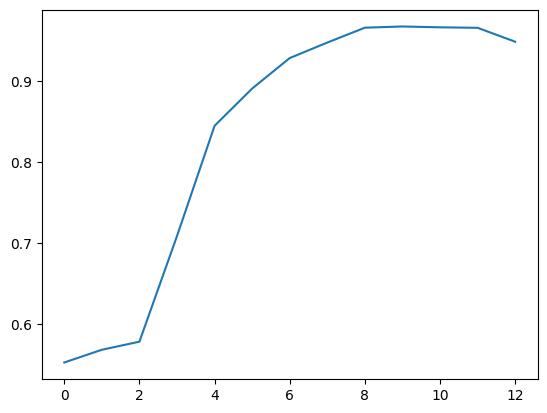

In [58]:
plt.plot( [i for i in range(len(reports_xor_no_control))], [report['accuracy'] for report in reports_xor_no_control],)

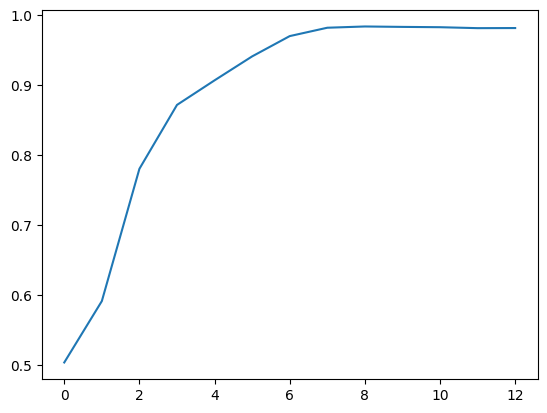

In [59]:
plt.plot( [i for i in range(len(reports_xor_no_control))], [report['accuracy'] for report in reports_xor_no_control_deberta],)

## Control Experiment
replace negation with gibberish and run the linear probes for inference

In [8]:

test_dataset_xor_1 = datasets.load_dataset("data_scripts/data_xor.py", task_num=1, cache_dir="control_task")["test"]

Found cached dataset data_xor (/home2/shashwat.s/main_thread/negation_new/{'cache_dir': 'control_task', 'config_name': None, 'data_dir': None, 'data_files': None, 'hash': 'd43629473a92fa6f8a1c126e61941540407d3b24b4970b1d59d93761d5895b71', 'features': None, 'use_auth_token': None, 'base_path': 'data_scripts', 'task_num': 1}/data_xor/default/0.0.0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [124]:
test_control1, test_labels_control1 = get_hidden_states_many_examples(model_wrapped, test_dataset_xor_1, n=10000, batch_size=100)


In [125]:
test_control1_deberta, test_labels_control1 = get_hidden_states_many_examples(model_wrapped_deberta, test_dataset_xor_1, n=10000, batch_size=100)


In [9]:
test_control1_bertnot, test_labels_control1 = get_hidden_states_many_examples(model_wrapped_bertnot, test_dataset_xor_1, n=10000, batch_size=100)


In [15]:
test_labels_control1

tensor([0, 1, 1,  ..., 1, 1, 0], device='cuda:0')

In [128]:
reports_xor_control_1 = generate_classification_report_all_layers(test_control1, test_labels_control1, models_xor)
reports_xor_control_1_deberta = generate_classification_report_all_layers(test_control1_deberta, test_labels_control1, models_deberta_xor)
class_0_xor_control_1, class_1_xor_control_1 = collect_all_precisions_recalls(reports_xor_control_1)
class_0_xor_control_1_deberta, class_1_xor_control_1_deberta = collect_all_precisions_recalls(reports_xor_control_1_deberta)
print(reports_xor_control_1[-1])
print(reports_xor_control_1_deberta[-1])


{'0': {'precision': 0.6521450685537373, 'recall': 0.8802985074626866, 'f1-score': 0.7492378048780488, 'support': 3350}, '1': {'precision': 0.8158861340679523, 'recall': 0.5304477611940298, 'f1-score': 0.6429088277858176, 'support': 3350}, 'accuracy': 0.7053731343283582, 'macro avg': {'precision': 0.7340156013108448, 'recall': 0.7053731343283582, 'f1-score': 0.6960733163319333, 'support': 6700}, 'weighted avg': {'precision': 0.7340156013108448, 'recall': 0.7053731343283582, 'f1-score': 0.6960733163319331, 'support': 6700}}
{'0': {'precision': 0.5596901835325813, 'recall': 0.9922388059701492, 'f1-score': 0.7156852190763268, 'support': 3350}, '1': {'precision': 0.9658344283837057, 'recall': 0.21940298507462686, 'f1-score': 0.3575772318170761, 'support': 3350}, 'accuracy': 0.605820895522388, 'macro avg': {'precision': 0.7627623059581434, 'recall': 0.605820895522388, 'f1-score': 0.5366312254467014, 'support': 6700}, 'weighted avg': {'precision': 0.7627623059581435, 'recall': 0.6058208955223

In [10]:
reports_xor_control_1_bertnot = generate_classification_report_all_layers(test_control1_bertnot, test_labels_control1, models_bertnot_xor)
print(reports_xor_control_1_bertnot[-1])


{'0': {'precision': 0.7793493635077794, 'recall': 0.8223880597014925, 'f1-score': 0.8002904865649964, 'support': 3350}, '1': {'precision': 0.8120063191153238, 'recall': 0.7671641791044777, 'f1-score': 0.7889485801995396, 'support': 3350}, 'accuracy': 0.7947761194029851, 'macro avg': {'precision': 0.7956778413115516, 'recall': 0.7947761194029851, 'f1-score': 0.794619533382268, 'support': 6700}, 'weighted avg': {'precision': 0.7956778413115516, 'recall': 0.7947761194029851, 'f1-score': 0.794619533382268, 'support': 6700}}


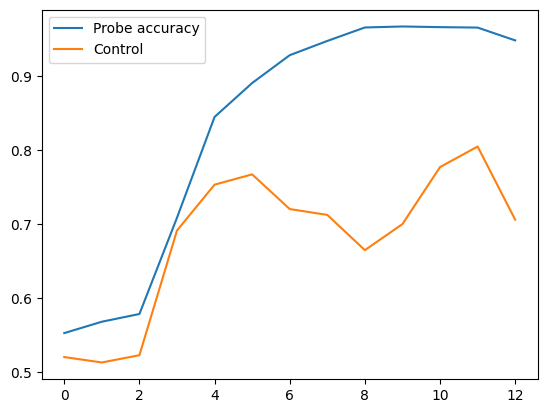

In [17]:
plt.plot( [i for i in range(len(reports_xor_no_control))], [report['accuracy'] for report in reports_xor_no_control], label="Probe accuracy")
plt.plot([i for i in range(len(reports_xor_control_1))], [report['accuracy'] for report in reports_xor_control_1], label="Control")
plt.legend()
plt.savefig("XOR_setup.svg", format="svg")

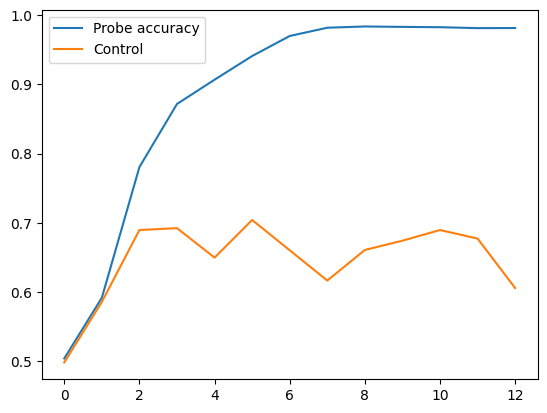

In [64]:
plt.plot( [i for i in range(len(reports_xor_no_control_deberta))], [report['accuracy'] for report in reports_xor_no_control_deberta], label="Probe accuracy")
plt.plot([i for i in range(len(reports_xor_control_1_deberta))], [report['accuracy'] for report in reports_xor_control_1_deberta], label="Control")
plt.legend()
plt.savefig("XOR_setup.svg", format="svg")

In [97]:
print(reports_xor_no_control[-1])
print(reports_xor_control_1[-1])

{'0': {'precision': 0.9485799701046338, 'recall': 0.9471641791044776, 'f1-score': 0.9478715459297984, 'support': 3350}, '1': {'precision': 0.9472429210134128, 'recall': 0.9486567164179105, 'f1-score': 0.9479492915734526, 'support': 3350}, 'accuracy': 0.947910447761194, 'macro avg': {'precision': 0.9479114455590233, 'recall': 0.947910447761194, 'f1-score': 0.9479104187516255, 'support': 6700}, 'weighted avg': {'precision': 0.9479114455590234, 'recall': 0.947910447761194, 'f1-score': 0.9479104187516255, 'support': 6700}}
{'0': {'precision': 0.6523662096417514, 'recall': 0.8805970149253731, 'f1-score': 0.7494918699186992, 'support': 3350}, '1': {'precision': 0.8163452708907254, 'recall': 0.5307462686567164, 'f1-score': 0.6432706222865412, 'support': 3350}, 'accuracy': 0.7056716417910448, 'macro avg': {'precision': 0.7343557402662384, 'recall': 0.7056716417910447, 'f1-score': 0.6963812461026202, 'support': 6700}, 'weighted avg': {'precision': 0.7343557402662384, 'recall': 0.705671641791044

In [65]:
print(reports_xor_no_control_deberta[-1])
print(reports_xor_control_1_deberta[-1])

{'0': {'precision': 0.9716374269005847, 'recall': 0.9919402985074627, 'f1-score': 0.9816838995568685, 'support': 3350}, '1': {'precision': 0.9917682926829269, 'recall': 0.971044776119403, 'f1-score': 0.9812971342383108, 'support': 3350}, 'accuracy': 0.9814925373134329, 'macro avg': {'precision': 0.9817028597917559, 'recall': 0.9814925373134329, 'f1-score': 0.9814905168975896, 'support': 6700}, 'weighted avg': {'precision': 0.9817028597917559, 'recall': 0.9814925373134329, 'f1-score': 0.9814905168975896, 'support': 6700}}
{'0': {'precision': 0.5596901835325813, 'recall': 0.9922388059701492, 'f1-score': 0.7156852190763268, 'support': 3350}, '1': {'precision': 0.9658344283837057, 'recall': 0.21940298507462686, 'f1-score': 0.3575772318170761, 'support': 3350}, 'accuracy': 0.605820895522388, 'macro avg': {'precision': 0.7627623059581434, 'recall': 0.605820895522388, 'f1-score': 0.5366312254467014, 'support': 6700}, 'weighted avg': {'precision': 0.7627623059581435, 'recall': 0.60582089552238

### Control 2
Actually formulation

In [11]:
test_dataset_xor_2 = datasets.load_dataset("data_scripts/data_xor.py", task_num=2, cache_dir="control_task")["test"]
# print(test_dataset_xor_2['content'])
# print(test_dataset_xor_2['label'])

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset data_xor downloaded and prepared to /home2/shashwat.s/main_thread/negation_new/{'cache_dir': 'control_task', 'config_name': None, 'data_dir': None, 'data_files': None, 'hash': 'd43629473a92fa6f8a1c126e61941540407d3b24b4970b1d59d93761d5895b71', 'features': None, 'use_auth_token': None, 'base_path': 'data_scripts', 'task_num': 2}/data_xor/default/0.0.0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
test_control2, test_labels_control2 = get_hidden_states_many_examples(model_wrapped, test_dataset_xor_2, n=10000, batch_size=100)
test_control2_deberta, test_labels_control2 = get_hidden_states_many_examples(model_wrapped_deberta, test_dataset_xor_2, n=10000, batch_size=100)



In [12]:
test_control2_bertnot, test_labels_control2 = get_hidden_states_many_examples(model_wrapped_bertnot, test_dataset_xor_2, n=10000, batch_size=100)


In [21]:
reports_xor_control_2 = generate_classification_report_all_layers(test_control2, test_labels_control2, models_xor)
reports_xor_control_2_deberta = generate_classification_report_all_layers(test_control2_deberta, test_labels_control2, models_deberta_xor)
# class_0_xor_control_2, class_2_xor_control_2 = collect_all_precisions_recalls(reports_xor_control_2)
# class_0_xor_control_2_deberta, class_1_xor_control_1_deberta = collect_all_precisions_recalls(reports_xor_control_1_deberta)
print(reports_xor_control_2[-1])
print(reports_xor_control_2_deberta[-1])
models_xor[-1].predict(test_control2[-1].detach().cpu().numpy()).mean()


{'0': {'precision': 0.48921765295887665, 'recall': 0.5823880597014925, 'f1-score': 0.5317525211229218, 'support': 3350}, '1': {'precision': 0.48414454277286134, 'recall': 0.3919402985074627, 'f1-score': 0.43319036621577034, 'support': 3350}, 'accuracy': 0.4871641791044776, 'macro avg': {'precision': 0.486681097865869, 'recall': 0.4871641791044776, 'f1-score': 0.4824714436693461, 'support': 6700}, 'weighted avg': {'precision': 0.486681097865869, 'recall': 0.4871641791044776, 'f1-score': 0.4824714436693461, 'support': 6700}}
{'0': {'precision': 0.4704782260219076, 'recall': 0.5256716417910448, 'f1-score': 0.4965458903143945, 'support': 3350}, '1': {'precision': 0.46263104497801827, 'recall': 0.4083582089552239, 'f1-score': 0.4338037101633106, 'support': 3350}, 'accuracy': 0.4670149253731343, 'macro avg': {'precision': 0.4665546354999629, 'recall': 0.4670149253731343, 'f1-score': 0.46517480023885255, 'support': 6700}, 'weighted avg': {'precision': 0.46655463549996296, 'recall': 0.46701492

0.4047761194029851

In [13]:
reports_xor_control_2_bertnot = generate_classification_report_all_layers(test_control2_bertnot, test_labels_control2, models_bertnot_xor)
print(reports_xor_control_2_bertnot[-1])


{'0': {'precision': 0.5470806614917314, 'recall': 0.48388059701492536, 'f1-score': 0.5135434817044195, 'support': 3350}, '1': {'precision': 0.5373294086165373, 'recall': 0.5994029850746269, 'f1-score': 0.5666713701142938, 'support': 3350}, 'accuracy': 0.5416417910447762, 'macro avg': {'precision': 0.5422050350541343, 'recall': 0.5416417910447762, 'f1-score': 0.5401074259093567, 'support': 6700}, 'weighted avg': {'precision': 0.5422050350541343, 'recall': 0.5416417910447762, 'f1-score': 0.5401074259093567, 'support': 6700}}


In [19]:
import datasets
import os
os.statvfs(datasets.config.HF_DATASETS_CACHE)

os.statvfs_result(f_bsize=1048576, f_frsize=1048576, f_blocks=34191575, f_bfree=8784346, f_bavail=7067914, f_files=549253120, f_ffree=355606529, f_favail=355606529, f_flag=4096, f_namemax=255)

# Negation Detection

Very dumb experiment, checking for negation in the statement (from mean-pooled reps)

In [14]:
train_dataset_neg_detect = datasets.load_dataset("data_scripts/data_detect_neg.py", add_sep=False)["train"]
test_dataset_neg_detect = datasets.load_dataset("data_scripts/data_detect_neg.py", add_sep=False)["test"]
dev_dataset_neg_detect = datasets.load_dataset("data_scripts/data_detect_neg.py", add_sep=False)["validation"]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset data_detect_neg downloaded and prepared to /home2/shashwat.s/main_thread/negation_new/{'cache_dir': None, 'config_name': None, 'data_dir': None, 'data_files': None, 'hash': 'bce3bb356f1ca8735795eb30b1fab970b7a6bc4d095de37f4986dda7d765b172', 'features': None, 'use_auth_token': None, 'base_path': 'data_scripts', 'add_sep': False}/data_detect_neg/default/0.0.0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset data_detect_neg (/home2/shashwat.s/main_thread/negation_new/{'cache_dir': None, 'config_name': None, 'data_dir': None, 'data_files': None, 'hash': 'bce3bb356f1ca8735795eb30b1fab970b7a6bc4d095de37f4986dda7d765b172', 'features': None, 'use_auth_token': None, 'base_path': 'data_scripts', 'add_sep': False}/data_detect_neg/default/0.0.0)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset data_detect_neg (/home2/shashwat.s/main_thread/negation_new/{'cache_dir': None, 'config_name': None, 'data_dir': None, 'data_files': None, 'hash': 'bce3bb356f1ca8735795eb30b1fab970b7a6bc4d095de37f4986dda7d765b172', 'features': None, 'use_auth_token': None, 'base_path': 'data_scripts', 'add_sep': False}/data_detect_neg/default/0.0.0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
train_dataset_neg_detect_control = datasets.load_dataset("data_scripts/data_detect_neg.py",control=1)["train"]
test_dataset_neg_detect_control = datasets.load_dataset("data_scripts/data_detect_neg.py", control=1)["test"]
dev_dataset_neg_detect_control = datasets.load_dataset("data_scripts/data_detect_neg.py", control=1)["validation"]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset data_detect_neg downloaded and prepared to /home2/shashwat.s/main_thread/negation_new/{'cache_dir': None, 'config_name': None, 'data_dir': None, 'data_files': None, 'hash': 'bce3bb356f1ca8735795eb30b1fab970b7a6bc4d095de37f4986dda7d765b172', 'features': None, 'use_auth_token': None, 'base_path': 'data_scripts', 'control': 1}/data_detect_neg/default/0.0.0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset data_detect_neg (/home2/shashwat.s/main_thread/negation_new/{'cache_dir': None, 'config_name': None, 'data_dir': None, 'data_files': None, 'hash': 'bce3bb356f1ca8735795eb30b1fab970b7a6bc4d095de37f4986dda7d765b172', 'features': None, 'use_auth_token': None, 'base_path': 'data_scripts', 'control': 1}/data_detect_neg/default/0.0.0)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset data_detect_neg (/home2/shashwat.s/main_thread/negation_new/{'cache_dir': None, 'config_name': None, 'data_dir': None, 'data_files': None, 'hash': 'bce3bb356f1ca8735795eb30b1fab970b7a6bc4d095de37f4986dda7d765b172', 'features': None, 'use_auth_token': None, 'base_path': 'data_scripts', 'control': 1}/data_detect_neg/default/0.0.0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
train_dataset_neg_detect_control2 = datasets.load_dataset("data_scripts/data_detect_neg.py",control=2)["train"]
test_dataset_neg_detect_control2 = datasets.load_dataset("data_scripts/data_detect_neg.py", control=2)["test"]
dev_dataset_neg_detect_control2 = datasets.load_dataset("data_scripts/data_detect_neg.py", control=2)["validation"]
# print(train_dataset_neg_detect_control2["content"])

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset data_detect_neg downloaded and prepared to /home2/shashwat.s/main_thread/negation_new/{'cache_dir': None, 'config_name': None, 'data_dir': None, 'data_files': None, 'hash': 'bce3bb356f1ca8735795eb30b1fab970b7a6bc4d095de37f4986dda7d765b172', 'features': None, 'use_auth_token': None, 'base_path': 'data_scripts', 'control': 2}/data_detect_neg/default/0.0.0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset data_detect_neg (/home2/shashwat.s/main_thread/negation_new/{'cache_dir': None, 'config_name': None, 'data_dir': None, 'data_files': None, 'hash': 'bce3bb356f1ca8735795eb30b1fab970b7a6bc4d095de37f4986dda7d765b172', 'features': None, 'use_auth_token': None, 'base_path': 'data_scripts', 'control': 2}/data_detect_neg/default/0.0.0)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset data_detect_neg (/home2/shashwat.s/main_thread/negation_new/{'cache_dir': None, 'config_name': None, 'data_dir': None, 'data_files': None, 'hash': 'bce3bb356f1ca8735795eb30b1fab970b7a6bc4d095de37f4986dda7d765b172', 'features': None, 'use_auth_token': None, 'base_path': 'data_scripts', 'control': 2}/data_detect_neg/default/0.0.0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [25]:
train_detect_neg, train_labels_det_neg = get_hidden_states_many_examples(model_wrapped, train_dataset_neg_detect, n=500, batch_size=100)


In [26]:
test_detect_neg, test_labels_det_neg = get_hidden_states_many_examples(model_wrapped, test_dataset_neg_detect, n=2000, batch_size=100)


In [54]:
test_detect_neg_con, test_labels_det_neg_con = get_hidden_states_many_examples(model_wrapped, test_dataset_neg_detect_control, n=2000, batch_size=100)


In [44]:
test_detect_neg_con2, test_labels_det_neg_con2 = get_hidden_states_many_examples(model_wrapped, test_dataset_neg_detect_control2, n=2000, batch_size=100)

In [55]:
train_detect_neg_deb, train_labels_det_neg_deb = get_hidden_states_many_examples(model_wrapped_deberta, train_dataset_neg_detect, n=500, batch_size=100)
test_detect_neg_deb, test_labels_det_neg_deb = get_hidden_states_many_examples(model_wrapped_deberta, test_dataset_neg_detect, n=2000, batch_size=100)
test_detect_neg_con_deb, test_labels_det_neg_con_deb = get_hidden_states_many_examples(model_wrapped_deberta, test_dataset_neg_detect_control, n=2000, batch_size=100)


In [22]:
test_detect_neg_con_bertnot, test_labels_det_neg_con_bertnot = get_hidden_states_many_examples(model_wrapped_bertnot, test_dataset_neg_detect_control, n=2000, batch_size=100)


In [49]:
train_detect_neg_deb, train_labels_det_neg_deb = get_hidden_states_many_examples(model_wrapped_deberta, train_dataset_neg_detect, n=500, batch_size=100)
test_detect_neg_deb, test_labels_det_neg_deb = get_hidden_states_many_examples(model_wrapped_deberta, test_dataset_neg_detect, n=2000, batch_size=100)
test_detect_neg_con2_deb, test_labels_det_neg_con2_deb = get_hidden_states_many_examples(model_wrapped_deberta, test_dataset_neg_detect_control2, n=2000, batch_size=100)


In [17]:
train_detect_neg_bertnot, train_labels_det_neg_bertnot = get_hidden_states_many_examples(model_wrapped_bertnot, train_dataset_neg_detect, n=500, batch_size=100)
test_detect_neg_bertnot, test_labels_det_neg_bertnot = get_hidden_states_many_examples(model_wrapped_bertnot, test_dataset_neg_detect, n=2000, batch_size=100)
test_detect_neg_con2_bertnot, test_labels_det_neg_con2_bertnot = get_hidden_states_many_examples(model_wrapped_bertnot, test_dataset_neg_detect_control2, n=2000, batch_size=100)


In [38]:
models_neg_det, accuracies = run_experiment_across_layers(linear_probe_experiment, train_detect_neg, train_labels_det_neg, test_detect_neg, test_labels_det_neg)
# class_0_neg_det, class_1_neg_det = collect_all_precisions_recalls(reports_neg_det)
models_neg_det_deb, accuracies = run_experiment_across_layers(linear_probe_experiment, train_detect_neg_deb, train_labels_det_neg_deb, test_detect_neg_deb, test_labels_det_neg_deb)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+02    |proj g|=  8.44786D+00

At iterate   50    f=  8.84967D+01    |proj g|=  3.60859D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769     60     69      1     0     0   9.816D-05   8.850D+01
  F =   88.496679182182973     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 v

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate   50    f=  4.53411D+01    |proj g|=  2.37485D-01

At iterate  100    f=  4.53362D+01    |proj g|=  2.69116D-01

At iterate  150    f=  4.52831D+01    |proj g|=  4.67842D-01

At iterate  200    f=  4.52486D+01    |proj g|=  1.30606D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    209    244      1     0     0   2.691D-02   4.525D+01
  F =   45.248580881951739     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iter

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    196    231      1     0     0   6.113D-04   3.869D+01
  F =   38.691594026812652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+02    |proj g|=  2.88128D+01

At iterate   50    f=  3.81723D+01    |proj g|=  1.60258D-01

At iterate  100    f=  3.80097D+01    |proj g|=  3.42992D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+02    |proj g|=  2.92555D+01

At iterate   50    f=  3.57445D+01    |proj g|=  2.11324D-01

At iterate  100    f=  3.57384D+01    |proj g|=  2.46547D-02

At iterate  150    f=  3.56476D+01    |proj g|=  3.07260D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    193    235      1     0     0   3.938D-02   3.565D+01
  F =   35.645565623345774     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    193    228      1     0     0   9.494D-03   3.565D+01
  F =   35.651419381952856     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+02    |proj g|=  2.99981D+01

At iterate   50    f=  3.79998D+01    |proj g|=  5.86586D-01

At iterate  100    f=  3.79581D+01    |proj g|=  2.56425D-02

At iterate  150    f=  3.79522D+01    |proj g|=  3.12802D-01

At iter

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate  150    f=  4.40267D+01    |proj g|=  1.39415D+00

At iterate  200    f=  4.40143D+01    |proj g|=  1.14765D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    217    251      1     0     0   2.691D-02   4.401D+01
  F =   44.014238498307051     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+02    |proj g|=  1.67564D+01

At iterate   50    f=  1.00627D+02    |proj g|=  6.08589D-01

At iter

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate   50    f=  2.83359D+01    |proj g|=  1.99419D-02

At iterate  100    f=  2.83175D+01    |proj g|=  2.14322D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    106    118      1     0     0   2.207D-03   2.832D+01
  F =   28.317486499827211     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+02    |proj g|=  9.73940D+01

At iterate   50    f=  2.38043D+01    |proj g|=  2.25803D-01

At iter

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate   50    f=  2.37637D+01    |proj g|=  6.42642D-02

At iterate  100    f=  2.36441D+01    |proj g|=  8.51637D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    109    130      1     0     0   4.837D-03   2.364D+01
  F =   23.644133672248138     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+02    |proj g|=  9.83045D+01

At iterate   50    f=  2.14221D+01    |proj g|=  3.45739D-02

At iter

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+02    |proj g|=  7.03326D+01

At iterate   50    f=  2.19940D+01    |proj g|=  1.22626D-01

At iterate  100    f=  2.19385D+01    |proj g|=  5.05424D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    149    169      1     0     0   3.719D-03   2.191D+01
  F =   21.910947048519795     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate   50    f=  2.95518D+01    |proj g|=  3.57873D-01

At iterate  100    f=  2.93922D+01    |proj g|=  7.64826D-01

At iterate  150    f=  2.93284D+01    |proj g|=  2.73468D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    171    202      1     0     0   4.637D-03   2.933D+01
  F =   29.328318877779573     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+02    |proj g|=  5.94829D+01

At iter

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [18]:
models_neg_det_bertnot, accuracies = run_experiment_across_layers(linear_probe_experiment, train_detect_neg_bertnot, train_labels_det_neg_bertnot, test_detect_neg_bertnot, test_labels_det_neg_bertnot)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+02    |proj g|=  1.83300D+01

At iterate   50    f=  3.72131D+01    |proj g|=  2.82468D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769     76     86      1     0     0   7.896D-04   3.721D+01
  F =   37.213067828943359     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 v

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate   50    f=  3.08342D+01    |proj g|=  2.41608D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769     70     83      1     0     0   6.321D-04   3.083D+01
  F =   30.833849159627015     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+02    |proj g|=  2.69549D+01

At iterate   50    f=  3.14319D+01    |proj g|=  3.78827D-02

At iterate  100    f=  3.14177D+01    |proj g|=  5.90741D-02

       

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



At iterate   50    f=  2.85623D+01    |proj g|=  3.91949D-02

At iterate  100    f=  2.84255D+01    |proj g|=  1.99604D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    146    169      1     0     0   5.330D-03   2.842D+01
  F =   28.423003881062961     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+02    |proj g|=  3.38399D+01

At iterate   50    f=  2.79514D+01    |proj g|=  1.56276D-01

At iter

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  769    153    177      1     0     0   2.367D-03   2.535D+01
  F =   25.350231938491447     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          769     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+02    |proj g|=  8.97874D+01

At iterate   50    f=  2.91017D+01    |proj g|=  1.49239D+00

At iterate  100    f=  2.77337D+01    |proj g|=  2.71306D-01

At iterate  150    f=  2.77326D+01    |proj g|=  2.80634D-03

       

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [39]:
reports_neg_det = generate_classification_report_all_layers(test_detect_neg, test_labels_det_neg, models_neg_det)
reports_neg_det_deb = generate_classification_report_all_layers(test_detect_neg_deb, test_labels_det_neg_deb, models_neg_det_deb)



In [19]:
reports_neg_det_bertnot = generate_classification_report_all_layers(test_detect_neg_bertnot, test_labels_det_neg_bertnot, models_neg_det_bertnot)


In [27]:
class_0_models_neg_det, class_1_models_neg_det = collect_all_precisions_recalls(reports_neg_det)

In [56]:
reports_neg_det_con = generate_classification_report_all_layers(test_detect_neg_con, test_labels_det_neg_con, models_neg_det)
reports_neg_det_con_deb = generate_classification_report_all_layers(test_detect_neg_con_deb, test_labels_det_neg_con_deb, models_neg_det_deb)


/home2/shashwat.s/anaconda3/envs/new_research_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/shashwat.s/anaconda3/envs/new_research_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/shashwat.s/anaconda3/envs/new_research_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [23]:
reports_neg_det_con_bertnot = generate_classification_report_all_layers(test_detect_neg_con_bertnot, test_labels_det_neg_con_bertnot, models_neg_det_bertnot)


In [50]:
reports_neg_det_con2 = generate_classification_report_all_layers(test_detect_neg_con2, test_labels_det_neg_con2, models_neg_det)
reports_neg_det_con2_deb = generate_classification_report_all_layers(test_detect_neg_con2_deb, test_labels_det_neg_con2_deb, models_neg_det_deb)


In [20]:
reports_neg_det_con2_bertnot = generate_classification_report_all_layers(test_detect_neg_con2_bertnot, test_labels_det_neg_con2_bertnot, models_neg_det_bertnot)


In [24]:
print(reports_neg_det_bertnot[-1])
print(reports_neg_det_con_bertnot[-1])
print(reports_neg_det_con2_bertnot[-1])

{'0': {'precision': 0.9773844641101278, 'recall': 0.994, 'f1-score': 0.9856222112047596, 'support': 1000}, '1': {'precision': 0.9938962360122076, 'recall': 0.977, 'f1-score': 0.9853756933938477, 'support': 1000}, 'accuracy': 0.9855, 'macro avg': {'precision': 0.9856403500611677, 'recall': 0.9855, 'f1-score': 0.9854989522993036, 'support': 2000}, 'weighted avg': {'precision': 0.9856403500611678, 'recall': 0.9855, 'f1-score': 0.9854989522993036, 'support': 2000}}
{'0': {'precision': 0.523709167544784, 'recall': 0.994, 'f1-score': 0.6859903381642513, 'support': 1000}, '1': {'precision': 0.9411764705882353, 'recall': 0.096, 'f1-score': 0.17422867513611615, 'support': 1000}, 'accuracy': 0.545, 'macro avg': {'precision': 0.7324428190665097, 'recall': 0.545, 'f1-score': 0.4301095066501837, 'support': 2000}, 'weighted avg': {'precision': 0.7324428190665097, 'recall': 0.545, 'f1-score': 0.4301095066501837, 'support': 2000}}
{'0': {'precision': 0.7362962962962963, 'recall': 0.994, 'f1-score': 0.

NameError: name 'reports_neg_det_con' is not defined

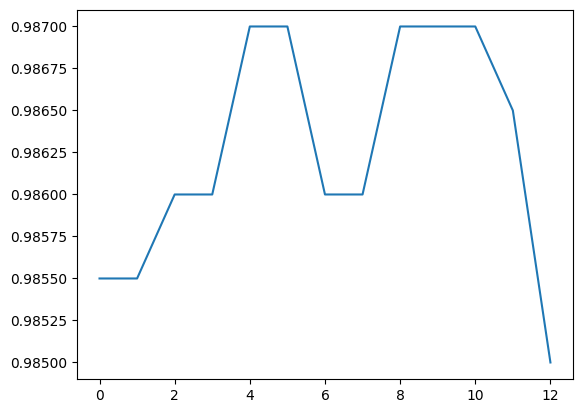

In [32]:
plt.plot([i for i in range(len(reports_neg_det))], [report['accuracy'] for report in reports_neg_det], label="Probe Accuracies")
plt.plot([i for i in range(len(reports_neg_det))], [report['accuracy'] for report in reports_neg_det_con], label="Control")
plt.legend()
plt.savefig("Negation_detect.svg", format="svg")

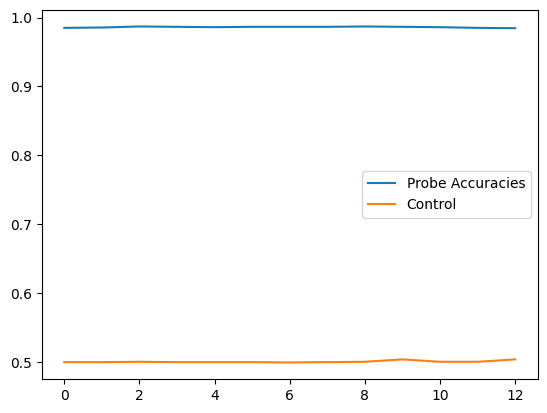

In [37]:
plt.plot([i for i in range(len(reports_neg_det_deb))], [report['accuracy'] for report in reports_neg_det_deb], label="Probe Accuracies")
plt.plot([i for i in range(len(reports_neg_det_deb))], [report['accuracy'] for report in reports_neg_det_con_deb], label="Control")
plt.legend()
plt.savefig("Negation_detect.svg", format="svg")

In [39]:
print(reports_neg_det[-1])

{'0': {'precision': 0.9727095516569201, 'recall': 0.998, 'f1-score': 0.985192497532083, 'support': 1000}, '1': {'precision': 0.997946611909651, 'recall': 0.972, 'f1-score': 0.9848024316109422, 'support': 1000}, 'accuracy': 0.985, 'macro avg': {'precision': 0.9853280817832855, 'recall': 0.985, 'f1-score': 0.9849974645715126, 'support': 2000}, 'weighted avg': {'precision': 0.9853280817832856, 'recall': 0.985, 'f1-score': 0.9849974645715126, 'support': 2000}}


In [41]:
print(reports_neg_det_deb[-1])

{'0': {'precision': 0.9773399014778326, 'recall': 0.992, 'f1-score': 0.9846153846153847, 'support': 1000}, '1': {'precision': 0.9918781725888325, 'recall': 0.977, 'f1-score': 0.9843828715365239, 'support': 1000}, 'accuracy': 0.9845, 'macro avg': {'precision': 0.9846090370333325, 'recall': 0.9844999999999999, 'f1-score': 0.9844991280759543, 'support': 2000}, 'weighted avg': {'precision': 0.9846090370333325, 'recall': 0.9845, 'f1-score': 0.9844991280759543, 'support': 2000}}


In [57]:
print(reports_neg_det_con[-1])
print(reports_neg_det_con_deb[-1])

{'0': {'precision': 0.5022647206844489, 'recall': 0.998, 'f1-score': 0.6682289922999666, 'support': 1000}, '1': {'precision': 0.8461538461538461, 'recall': 0.011, 'f1-score': 0.021717670286278377, 'support': 1000}, 'accuracy': 0.5045, 'macro avg': {'precision': 0.6742092834191475, 'recall': 0.5045, 'f1-score': 0.34497333129312246, 'support': 2000}, 'weighted avg': {'precision': 0.6742092834191475, 'recall': 0.5045, 'f1-score': 0.34497333129312246, 'support': 2000}}
{'0': {'precision': 0.5020242914979757, 'recall': 0.992, 'f1-score': 0.6666666666666667, 'support': 1000}, '1': {'precision': 0.6666666666666666, 'recall': 0.016, 'f1-score': 0.03125, 'support': 1000}, 'accuracy': 0.504, 'macro avg': {'precision': 0.5843454790823212, 'recall': 0.504, 'f1-score': 0.34895833333333337, 'support': 2000}, 'weighted avg': {'precision': 0.5843454790823212, 'recall': 0.504, 'f1-score': 0.34895833333333337, 'support': 2000}}


In [51]:
print(reports_neg_det_con2[-1])

{'0': {'precision': 0.5184415584415585, 'recall': 0.998, 'f1-score': 0.6823931623931625, 'support': 1000}, '1': {'precision': 0.9733333333333334, 'recall': 0.073, 'f1-score': 0.13581395348837208, 'support': 1000}, 'accuracy': 0.5355, 'macro avg': {'precision': 0.7458874458874459, 'recall': 0.5355, 'f1-score': 0.4091035579407673, 'support': 2000}, 'weighted avg': {'precision': 0.7458874458874459, 'recall': 0.5355, 'f1-score': 0.40910355794076725, 'support': 2000}}


In [52]:
print(reports_neg_det_con2_deb[-1])

{'0': {'precision': 0.5911799761620977, 'recall': 0.992, 'f1-score': 0.7408513816280807, 'support': 1000}, '1': {'precision': 0.9751552795031055, 'recall': 0.314, 'f1-score': 0.4750378214826021, 'support': 1000}, 'accuracy': 0.653, 'macro avg': {'precision': 0.7831676278326016, 'recall': 0.653, 'f1-score': 0.6079446015553414, 'support': 2000}, 'weighted avg': {'precision': 0.7831676278326017, 'recall': 0.653, 'f1-score': 0.6079446015553415, 'support': 2000}}


In [30]:
# class_0_models_neg_det
# class_1_models_neg_det

# Negation Consistency Probe

In [4]:
ic.disable()
train_dataset_neg_consistency_rob = datasets.load_dataset("data_scripts/data_negation_consistency.py")["train"]
test_dataset_neg_consistency_rob = datasets.load_dataset("data_scripts/data_negation_consistency.py")["test"]
dev_dataset_neg_consistency_rob = datasets.load_dataset("data_scripts/data_negation_consistency.py")["validation"]

/home2/shashwat.s/anaconda3/envs/new_research_env/lib/python3.9/site-packages/transformers/models/auto/modeling_auto.py:1177: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
Found cached dataset data_negation_consistency (/home2/shashwat.s/main_thread/negation_new/{'cache_dir': None, 'config_name': None, 'data_dir': None, 'data_files': None, 'hash': '56f967f91a1d77b83131c2ef0c8739577bc6cb74fe7ad6a208c0a08b297892bd', 'features': None, 'use_auth_token': None, 'base_path': 'data_scripts'}/data_negation_consistency/default/0.0.0)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset data_negation_consistency (/home2/shashwat.s/main_thread/negation_new/{'cache_dir': None, 'config_name': None, 'data_dir': None, 'data_files': None, 'hash': '56f967f91a1d77b83131c2ef0c8739577bc6cb74fe7ad6a208c0a08b297892bd', 'features': None, 'use_auth_token': None, 'base_path': 'data_scripts'}/data_negation_consistency/default/0.0.0)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset data_negation_consistency (/home2/shashwat.s/main_thread/negation_new/{'cache_dir': None, 'config_name': None, 'data_dir': None, 'data_files': None, 'hash': '56f967f91a1d77b83131c2ef0c8739577bc6cb74fe7ad6a208c0a08b297892bd', 'features': None, 'use_auth_token': None, 'base_path': 'data_scripts'}/data_negation_consistency/default/0.0.0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
ic.disable()
train_dataset_neg_consistency_deb = datasets.load_dataset("data_scripts/data_negation_consistency.py", model_name='microsoft/deberta-base')["train"]
test_dataset_neg_consistency_deb = datasets.load_dataset("data_scripts/data_negation_consistency.py", model_name='microsoft/deberta-base')["test"]
dev_dataset_neg_consistency_deb = datasets.load_dataset("data_scripts/data_negation_consistency.py", model_name='microsoft/deberta-base')["validation"]

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForMaskedLM: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'deberta.embeddings.position_embeddings.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForMaskedLM were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['cls.predictions.transform.dense.bias

  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForMaskedLM: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'deberta.embeddings.position_embeddings.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForMaskedLM were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['cls.predictions.transform.dense.bias

  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForMaskedLM: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'deberta.embeddings.position_embeddings.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForMaskedLM were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['cls.predictions.transform.dense.bias

  0%|          | 0/3 [00:00<?, ?it/s]

In [20]:
ic.disable()
model_wrapped_bertnot.model_obj.__str__ = lambda x: "bertnot"
model_wrapped_bertnot.tokenizer_obj.__str__ = lambda x: "bert-tokenizer"
print(model_wrapped_bertnot.model_obj.__repr__())
train_dataset_neg_consistency_bertnot = datasets.load_dataset("data_scripts/data_negation_consistency.py", model=model_wrapped_bertnot.model_obj, tokenizer=model_wrapped_bertnot.tokenizer_obj)["train"]
test_dataset_neg_consistency_bertnot = datasets.load_dataset("data_scripts/data_negation_consistency.py", model=model_wrapped_bertnot.model_obj, tokenizer=model_wrapped_bertnot.tokenizer_obj)["test"]
dev_dataset_neg_consistency_bertnot = datasets.load_dataset("data_scripts/data_negation_consistency.py", model=model_wrapped_bertnot.model_obj, tokenizer=model_wrapped_bertnot.tokenizer_obj)["validation"]

TypeError: <lambda>() missing 1 required positional argument: 'x'

In [10]:
from data_scripts.data_negation_consistency import *
sum_bertnot = 0
total_bertnot = 0
with open(TEST_LAMA, "r") as f:
    id_ = 0
    for id_quintuple, line in enumerate(f):
        total_bertnot += 1
        id_ += 1
        try:
            dict_rep = json.loads(line)
        except json.decoder.JSONDecodeError:
            pass
        mask_replace = "<mask>"
        pair_of_pair = (
            dict_rep["masked_sentences"][0],
            dict_rep["masked_negations"][0],
        )

        subject = dict_rep["sub_label"]
        masked_non_negated = pair_of_pair[0]
        model_wrapped_bertnot.cpu()
        print(pair_of_pair)
        try:
            label = compare_n_sentences(model_wrapped_bertnot.model_lm, model_wrapped_bertnot.tokenizer_obj, pair_of_pair)
        except IndexError:
            continue

        # subject_hidden = replace_substring_with_mask(masked_non_negated, subject, self.mask_token)
        sum_bertnot += 1
        print( (id_), {
            "subject": subject,
            "masked_non_negated": masked_non_negated,
            # "subject_hidden": subject_hidden,
            "label": label,
            "id_": id_
        })

print(sum_bertnot)
print(total_bertnot)
print(sum_bertnot/total_bertnot)


('Piero Gobetti used to communicate in [MASK] .', 'Piero Gobetti not used to communicate in [MASK] .')
1 {'subject': 'Piero Gobetti', 'masked_non_negated': 'Piero Gobetti used to communicate in [MASK] .', 'label': False, 'id_': 1}
('The original language of Thulladha Manamum Thullum is [MASK] .', 'The original language of Thulladha Manamum Thullum is not [MASK] .')
2 {'subject': 'Thulladha Manamum Thullum', 'masked_non_negated': 'The original language of Thulladha Manamum Thullum is [MASK] .', 'label': True, 'id_': 2}
('Fiat Siena is produced by [MASK] .', 'Fiat Siena is not produced by [MASK] .')
3 {'subject': 'Fiat Siena', 'masked_non_negated': 'Fiat Siena is produced by [MASK] .', 'label': False, 'id_': 3}
('ferric phosphate consists of [MASK] .', 'ferric phosphate does not consist of [MASK] .')
4 {'subject': 'ferric phosphate', 'masked_non_negated': 'ferric phosphate consists of [MASK] .', 'label': True, 'id_': 4}
('Carlos Fuentes used to communicate in [MASK] .', 'Carlos Fuentes n

In [6]:
train_dataset_neg_consistency_rob['subject_hidden']

['The official language of <mask> is <mask>.',
 'Information is a <mask><mask>n is a <mask>.',
 '<mask> is a legal term in <mask>.',
 'The native language of <mask> is <mask>.',
 '<mask> is located in <mask>.',
 'The native language of <mask> is <mask>.',
 'The Crips is a type of <mask><mask>Crips is a type of <mask>.',
 '<mask> is developed by <mask>.',
 '<mask> is named after <mask>.',
 '<mask> is located in <mask>.',
 '<mask> is a legal term in <mask>.',
 '<mask> was written in <mask>.',
 '<mask> is part of <mask>.',
 '<mask> is produced by <mask>.',
 '<mask> is produced by <mask>.',
 '<mask> is developed by <mask>.',
 '<mask> is located in <mask>.',
 '<mask> is produced by <mask>.',
 'The original language of <mask> is <mask>.',
 'The native language of <mask> is <mask>.',
 '<mask> is produced by <mask>.',
 '<mask> is a subclass of <mask>.',
 '<mask> consists of <mask>.',
 '<mask> was originally aired on <mask>.',
 '<mask> is developed by <mask>.',
 '<mask> is part of <mask>.',
 'T

In [7]:
train_dataset_neg_consistency_sorted_rob = train_dataset_neg_consistency_rob.sort('label', )
test_dataset_neg_consistency_sorted_rob = test_dataset_neg_consistency_rob.sort('label', )
dev_dataset_neg_consistency_sorted_rob = dev_dataset_neg_consistency_rob.sort('label', )

Loading cached sorted indices for dataset at /home2/shashwat.s/main_thread/negation_new/{'cache_dir': None, 'config_name': None, 'data_dir': None, 'data_files': None, 'hash': '56f967f91a1d77b83131c2ef0c8739577bc6cb74fe7ad6a208c0a08b297892bd', 'features': None, 'use_auth_token': None, 'base_path': 'data_scripts'}/data_negation_consistency/default/0.0.0/cache-d8b1821e996431b7.arrow
Loading cached sorted indices for dataset at /home2/shashwat.s/main_thread/negation_new/{'cache_dir': None, 'config_name': None, 'data_dir': None, 'data_files': None, 'hash': '56f967f91a1d77b83131c2ef0c8739577bc6cb74fe7ad6a208c0a08b297892bd', 'features': None, 'use_auth_token': None, 'base_path': 'data_scripts'}/data_negation_consistency/default/0.0.0/cache-669296e49a91b7cd.arrow
Loading cached sorted indices for dataset at /home2/shashwat.s/main_thread/negation_new/{'cache_dir': None, 'config_name': None, 'data_dir': None, 'data_files': None, 'hash': '56f967f91a1d77b83131c2ef0c8739577bc6cb74fe7ad6a208c0a08b29

In [9]:
train_dataset_neg_consistency_sorted_deb = train_dataset_neg_consistency_deb.sort('label', )
test_dataset_neg_consistency_sorted_deb = test_dataset_neg_consistency_deb.sort('label', )
dev_dataset_neg_consistency_sorted_deb = dev_dataset_neg_consistency_deb.sort('label', )

Loading cached sorted indices for dataset at /home2/shashwat.s/main_thread/negation_new/{'cache_dir': None, 'config_name': None, 'data_dir': None, 'data_files': None, 'hash': '56f967f91a1d77b83131c2ef0c8739577bc6cb74fe7ad6a208c0a08b297892bd', 'features': None, 'use_auth_token': None, 'base_path': 'data_scripts', 'model_name': 'microsoft/deberta-base'}/data_negation_consistency/default/0.0.0/cache-d8b1821e996431b7.arrow
Loading cached sorted indices for dataset at /home2/shashwat.s/main_thread/negation_new/{'cache_dir': None, 'config_name': None, 'data_dir': None, 'data_files': None, 'hash': '56f967f91a1d77b83131c2ef0c8739577bc6cb74fe7ad6a208c0a08b297892bd', 'features': None, 'use_auth_token': None, 'base_path': 'data_scripts', 'model_name': 'microsoft/deberta-base'}/data_negation_consistency/default/0.0.0/cache-669296e49a91b7cd.arrow
Loading cached sorted indices for dataset at /home2/shashwat.s/main_thread/negation_new/{'cache_dir': None, 'config_name': None, 'data_dir': None, 'data_f

In [10]:
train_dataset_neg_consistency_sorted_cut_rob = torch.utils.data.Subset(train_dataset_neg_consistency_sorted_rob, [i for i in range(int(0.16*len(train_dataset_neg_consistency_sorted_rob)), len(train_dataset_neg_consistency_sorted_rob))])
# train_dataset_neg_consistency_sorted_cut_deb = torch.utils.data.Subset(train_dataset_neg_consistency_sorted_deb, [i for i in range(int(0.16*len(train_dataset_neg_consistency_sorted_deb)), len(train_dataset_neg_consistency_sorted_deb))])

# train_dataset_neg_consistency_sorted_cut['label']
# type(train_dataset_neg_consistency_sorted_cut)

print(train_dataset_neg_consistency_sorted_cut_rob[0])
# print(train_dataset_neg_consistency_sorted_cut_deb[0])




{'id_': 2156, 'subject': 'Different Class', 'label': 0, 'masked_non_negated': 'Different Class was written in <mask>.', 'subject_hidden': '<mask> was written in <mask>.'}


In [11]:
# checking for statistics
# len(train_dataset_neg_consistency_sorted_cut['label'])
total = 0
ones = 0

for entry in train_dataset_neg_consistency_sorted_cut_rob:
    label = entry['label']
    total += 1
    ones += label

print(total)
print(ones)
print(ones/total)

# checking for statistics
# len(train_dataset_neg_consistency_sorted_cut['label'])
total = 0
ones = 0

for entry in dev_dataset_neg_consistency_deb:
    label = entry['label']
    total += 1
    ones += label

print(total)
print(ones)
print(ones/total)

6564
3339
0.5086837294332724
1674
756
0.45161290322580644


In [ ]:
len(set(train_dataset_neg_consistency['subject']).intersection(set(test_dataset_neg_consistency['subject'])))

In [37]:
len(set(test_dataset_neg_consistency['subject']))

1654

In [16]:
train_detect_neg_consistency, train_labels_det_neg_consistency = get_hidden_states_many_examples(model_wrapped, train_dataset_neg_consistency_sorted_cut_rob, n=8000, batch_size=100, query_column="subject")

In [17]:
val_detect_neg_consistency, val_labels_det_neg_consistency = get_hidden_states_many_examples(model_wrapped, dev_dataset_neg_consistency_rob, n=2000, batch_size=100, query_column="subject")

In [18]:
test_detect_neg_consistency, test_labels_det_neg_consistency = get_hidden_states_many_examples(model_wrapped, test_dataset_neg_consistency_rob, n=2000, batch_size=100, query_column="subject")

In [19]:
train_detect_neg_consistency_deb, train_labels_det_neg_consistency_deb = get_hidden_states_many_examples(model_wrapped_deberta, train_dataset_neg_consistency_deb, n=8000, batch_size=100, query_column="subject")
test_detect_neg_consistency_deb, test_labels_det_neg_consistency_deb = get_hidden_states_many_examples(model_wrapped_deberta, test_dataset_neg_consistency_deb, n=2000, batch_size=100, query_column="subject")
val_detect_neg_consistency_deb, val_labels_det_neg_consistency_deb = get_hidden_states_many_examples(model_wrapped_deberta, dev_dataset_neg_consistency_deb, n=2000, batch_size=100, query_column="subject")


In [20]:
print(train_detect_neg_consistency[0].size())
print(val_detect_neg_consistency[0].size())
print(val_detect_neg_consistency_deb[0].size())


torch.Size([6564, 768])
torch.Size([1674, 768])
torch.Size([1674, 768])


In [23]:
train_val_detect_neg_consistency = [torch.cat((train_detect_neg_consistency[i], val_detect_neg_consistency[i]), dim=0) for i in range(len(train_detect_neg_consistency))]
train_val_detect_neg_consistency_label = torch.cat((train_labels_det_neg_consistency, val_labels_det_neg_consistency), dim=0)


In [24]:
train_val_detect_neg_consistency_deb = [torch.cat((train_detect_neg_consistency_deb[i], val_detect_neg_consistency_deb[i]), dim=0) for i in range(len(train_detect_neg_consistency_deb))]
train_val_detect_neg_consistency_label_deb = torch.cat((train_labels_det_neg_consistency_deb, val_labels_det_neg_consistency_deb), dim=0)


In [59]:
print(train_val_detect_neg_consistency[0].size())
print(train_val_detect_neg_consistency_label.size())

torch.Size([8238, 768])
torch.Size([8238])


In [16]:
def mlp_probe_experiment_custom(train_input, test_input, train_labels, test_labels):
    # initialize an mlp probe and run probe experiment
    mlp = MLPClassifier(random_state=1, max_iter=1000, verbose=True, hidden_layer_sizes=(300, 200), early_stopping=True, validation_fraction=0.2)
    print("here")
    return probe_experiment(train_input, test_input, train_labels, test_labels, mlp)


In [25]:
mlps_neg_consistency, accuracies = run_experiment_across_layers(mlp_probe_experiment_custom, train_val_detect_neg_consistency, train_val_detect_neg_consistency_label, test_detect_neg_consistency, test_labels_det_neg_consistency)


here
Iteration 1, loss = 0.66440987
Validation score: 0.597087
Iteration 2, loss = 0.60283062
Validation score: 0.629854
Iteration 3, loss = 0.57180405
Validation score: 0.641383
Iteration 4, loss = 0.52834699
Validation score: 0.651699
Iteration 5, loss = 0.47144437
Validation score: 0.637136
Iteration 6, loss = 0.40435305
Validation score: 0.625000
Iteration 7, loss = 0.32172038
Validation score: 0.625607
Iteration 8, loss = 0.24874503
Validation score: 0.633495
Iteration 9, loss = 0.16454664
Validation score: 0.640170
Iteration 10, loss = 0.15205773
Validation score: 0.620146
Iteration 11, loss = 0.13279510
Validation score: 0.628641
Iteration 12, loss = 0.09415461
Validation score: 0.632282
Iteration 13, loss = 0.08582100
Validation score: 0.626820
Iteration 14, loss = 0.08400399
Validation score: 0.628641
Iteration 15, loss = 0.07970272
Validation score: 0.627427
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
here
Iteration 1, loss = 0

In [26]:
mlps_neg_consistency_deb, accuracies = run_experiment_across_layers(mlp_probe_experiment_custom, train_val_detect_neg_consistency_deb, train_val_detect_neg_consistency_label_deb, test_detect_neg_consistency_deb, test_labels_det_neg_consistency_deb)


here
Iteration 1, loss = 0.67430802
Validation score: 0.609589
Iteration 2, loss = 0.60952892
Validation score: 0.616965
Iteration 3, loss = 0.54693048
Validation score: 0.619600
Iteration 4, loss = 0.46741723
Validation score: 0.597998
Iteration 5, loss = 0.36457291
Validation score: 0.587987
Iteration 6, loss = 0.26203673
Validation score: 0.583772
Iteration 7, loss = 0.19024868
Validation score: 0.591675
Iteration 8, loss = 0.14579539
Validation score: 0.580611
Iteration 9, loss = 0.13472646
Validation score: 0.599579
Iteration 10, loss = 0.13078669
Validation score: 0.592202
Iteration 11, loss = 0.10618890
Validation score: 0.596417
Iteration 12, loss = 0.09873862
Validation score: 0.594310
Iteration 13, loss = 0.08963956
Validation score: 0.603267
Iteration 14, loss = 0.08604529
Validation score: 0.592202
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
here
Iteration 1, loss = 0.68131020
Validation score: 0.595890
Iteration 2, loss = 0.

In [27]:
reports_neg_consistency = generate_classification_report_all_layers(test_detect_neg_consistency, test_labels_det_neg_consistency, mlps_neg_consistency)
class_0_neg_con, class_1_neg_con = collect_all_precisions_recalls(reports_neg_consistency)

In [28]:
reports_neg_consistency_deb = generate_classification_report_all_layers(test_detect_neg_consistency_deb, test_labels_det_neg_consistency_deb, mlps_neg_consistency_deb)


In [42]:
# class_1_neg_con

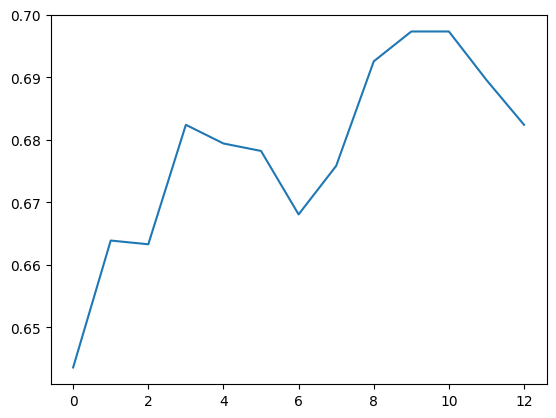

In [66]:
plt.plot([i for i in range(len(reports_neg_consistency))], [report['accuracy'] for report in reports_neg_consistency], label="Accuracy")

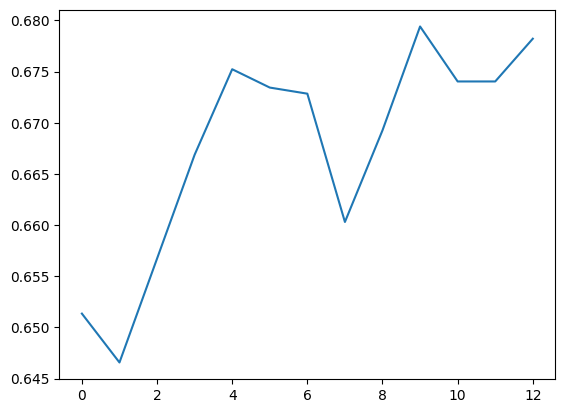

In [67]:
plt.plot([i for i in range(len(reports_neg_consistency_deb))], [report['accuracy'] for report in reports_neg_consistency_deb], label="Accuracy")

In [29]:
print(reports_neg_consistency[-1])
print(reports_neg_consistency_deb[-1])


{'0': {'precision': 0.7374860956618465, 'recall': 0.6949685534591195, 'f1-score': 0.7155963302752294, 'support': 954}, '1': {'precision': 0.625, 'recall': 0.6726768377253814, 'f1-score': 0.6479625918503674, 'support': 721}, 'accuracy': 0.6853731343283582, 'macro avg': {'precision': 0.6812430478309233, 'recall': 0.6838226955922504, 'f1-score': 0.6817794610627984, 'support': 1675}, 'weighted avg': {'precision': 0.6890667076187473, 'recall': 0.6853731343283582, 'f1-score': 0.686483538989065, 'support': 1675}}
{'0': {'precision': 0.6782810685249709, 'recall': 0.6410537870472008, 'f1-score': 0.6591422121896162, 'support': 911}, '1': {'precision': 0.5982800982800983, 'recall': 0.637434554973822, 'f1-score': 0.6172370088719898, 'support': 764}, 'accuracy': 0.6394029850746269, 'macro avg': {'precision': 0.6382805834025347, 'recall': 0.6392441710105115, 'f1-score': 0.638189610530803, 'support': 1675}, 'weighted avg': {'precision': 0.641791073738653, 'recall': 0.6394029850746269, 'f1-score': 0.6

In [ ]:
plt.plot([i for i in range(len(reports_neg_consistency))], [class_0_neg_con[i]['precision'] for i in range(len(class_0_neg_con))])
plt.plot([i for i in range(len(reports_neg_consistency))], [class_1_neg_con[i]['precision'] for i in range(len(class_1_neg_con))])

In [ ]:
plt.plot([i for i in range(len(reports_neg_consistency))], [class_0_neg_con[i]['recall'] for i in range(len(class_0_neg_con))])
plt.plot([i for i in range(len(reports_neg_consistency))], [class_1_neg_con[i]['recall'] for i in range(len(class_1_neg_con))])

In [ ]:
test_dataset_neg_consistency["masked_non_negated"][:5000]

In [ ]:
train_dataset_neg_detect["content"][:5000]


In [ ]:
import pytorch_lightning
import os
os.environ['SLURM_NTASKS_PER_NODE'] = '10'
train_dataset = DirtyDataset(train_detect_neg_consistency, train_labels_det_neg_consistency)
val_dataset = DirtyDataset(val_detect_neg_consistency, val_labels_det_neg_consistency)
test_dataset = DirtyDataset(test_detect_neg_consistency, test_labels_det_neg_consistency)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset))


pl_cons_model_rob = AcrossLayerfit(lr=0.001)

early_stopping = pytorch_lightning.callbacks.EarlyStopping('validation_loss', min_delta=0.0001, patience=10)
trainer = pytorch_lightning.Trainer(callbacks=[early_stopping], accelerator="gpu")

trainer.fit(model=pl_cons_model_rob, train_dataloaders=train_loader, val_dataloaders=val_loader, )


In [73]:
trainer.test(model=pl_cons_model_rob, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.6919403076171875
        test_loss           0.5891217589378357
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5891217589378357, 'test_accuracy': 0.6919403076171875}]

In [ ]:
import pytorch_lightning
import os
os.environ['SLURM_NTASKS_PER_NODE'] = '10'
train_dataset_deb = DirtyDataset(train_detect_neg_consistency_deb, train_labels_det_neg_consistency_deb)
val_dataset_deb = DirtyDataset(val_detect_neg_consistency_deb, val_labels_det_neg_consistency_deb)
test_dataset_deb = DirtyDataset(test_detect_neg_consistency_deb, test_labels_det_neg_consistency_deb)

train_loader_deb = torch.utils.data.DataLoader(train_dataset_deb, batch_size=len(train_dataset_deb))
test_loader_deb = torch.utils.data.DataLoader(test_dataset_deb, batch_size=len(test_dataset_deb))
val_loader_deb = torch.utils.data.DataLoader(val_dataset_deb, batch_size=len(val_dataset_deb))


pl_cons_model_deb = AcrossLayerfit(lr=0.001)

early_stopping = pytorch_lightning.callbacks.EarlyStopping('validation_loss', min_delta=0.0001, patience=10)
trainer = pytorch_lightning.Trainer(callbacks=[early_stopping], accelerator="gpu")

trainer.fit(model=pl_cons_model_deb, train_dataloaders=train_loader_deb, val_dataloaders=val_loader_deb, )


In [87]:
trainer.test(model=pl_cons_model_deb, dataloaders=test_loader_deb)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home2/shashwat.s/anaconda3/envs/new_research_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.6841791272163391
        test_loss           0.5941505432128906
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5941505432128906, 'test_accuracy': 0.6841791272163391}]

In [16]:
pl_cons_model_rob.softmax(pl_cons_model_rob.learnable_parameters)

tensor([0.1770, 0.0432, 0.0205, 0.0403, 0.0234, 0.0368, 0.0425, 0.3186, 0.0421,
        0.0530, 0.0297, 0.0279, 0.1451], grad_fn=<SoftmaxBackward0>)

In [91]:
import sklearn
pl_cons_model_rob.cuda()
pl_cons_model_deb.cuda()
rob_cons_outs = torch.where(pl_cons_model_rob(next(iter(test_loader))[0]) > 0.5, 1, 0)
deb_cons_outs = torch.where(pl_cons_model_deb(next(iter(test_loader_deb))[0]) > 0.5, 1, 0)

# call sklearn classification report metric function with the prediction as rob_cons_outs and target as test_labels_det_neg_consistency
# print the classification report
# use named parameters to pass the arguments
print(sklearn.metrics.classification_report(y_true=test_labels_det_neg_consistency.cpu().numpy(), y_pred=rob_cons_outs.detach().cpu().numpy(), output_dict=True))
print(sklearn.metrics.classification_report(y_true=test_labels_det_neg_consistency_deb.cpu().numpy(), y_pred=deb_cons_outs.detach().cpu().numpy(), output_dict=True))

{'0': {'precision': 0.7523041474654378, 'recall': 0.6844863731656184, 'f1-score': 0.716794731064764, 'support': 954}, '1': {'precision': 0.6270136307311028, 'recall': 0.7018030513176144, 'f1-score': 0.662303664921466, 'support': 721}, 'accuracy': 0.6919402985074626, 'macro avg': {'precision': 0.6896588890982703, 'recall': 0.6931447122416164, 'f1-score': 0.689549197993115, 'support': 1675}, 'weighted avg': {'precision': 0.6983731250383002, 'recall': 0.6919402985074626, 'f1-score': 0.6933391736383056, 'support': 1675}}
{'0': {'precision': 0.6833976833976834, 'recall': 0.6523341523341524, 'f1-score': 0.6675047140163419, 'support': 814}, '1': {'precision': 0.6848552338530067, 'recall': 0.7142857142857143, 'f1-score': 0.6992609437180217, 'support': 861}, 'accuracy': 0.684179104477612, 'macro avg': {'precision': 0.684126458625345, 'recall': 0.6833099333099333, 'f1-score': 0.6833828288671818, 'support': 1675}, 'weighted avg': {'precision': 0.6841469078406883, 'recall': 0.684179104477612, 'f1-

## Negation consistency given entire sentence

In [93]:
train_detect_neg_consistency_ful_rob, train_labels_det_neg_consistency_rob = get_hidden_states_many_examples(model_wrapped, train_dataset_neg_consistency_sorted_cut_rob, n=8000, batch_size=100, query_column="masked_non_negated")


In [94]:
test_detect_neg_consistency_ful_rob, test_labels_det_neg_consistency_rob = get_hidden_states_many_examples(model_wrapped, test_dataset_neg_consistency_rob, n=2000, batch_size=100, query_column="masked_non_negated")


In [95]:
val_detect_neg_consistency_ful_rob, val_labels_det_neg_consistency_rob = get_hidden_states_many_examples(model_wrapped, dev_dataset_neg_consistency_rob, n=2000, batch_size=100, query_column="masked_non_negated")


In [97]:
mlps_neg_con_full_rob, accuracies = run_experiment_across_layers(mlp_probe_experiment_custom, train_detect_neg_consistency_ful_rob, train_labels_det_neg_consistency_rob, test_detect_neg_consistency_ful_rob, test_labels_det_neg_consistency_rob)



here
Iteration 1, loss = 0.60613895
Validation score: 0.728865
Iteration 2, loss = 0.51308782
Validation score: 0.763899
Iteration 3, loss = 0.47647414
Validation score: 0.765423
Iteration 4, loss = 0.45915471
Validation score: 0.738005
Iteration 5, loss = 0.45208324
Validation score: 0.761615
Iteration 6, loss = 0.44034563
Validation score: 0.770754
Iteration 7, loss = 0.41684841
Validation score: 0.778370
Iteration 8, loss = 0.41040603
Validation score: 0.774562
Iteration 9, loss = 0.39879553
Validation score: 0.769992
Iteration 10, loss = 0.37789626
Validation score: 0.754760
Iteration 11, loss = 0.35898059
Validation score: 0.766184
Iteration 12, loss = 0.32833775
Validation score: 0.763138
Iteration 13, loss = 0.30285509
Validation score: 0.764661
Iteration 14, loss = 0.27528387
Validation score: 0.761615
Iteration 15, loss = 0.25049963
Validation score: 0.749429
Iteration 16, loss = 0.21283037
Validation score: 0.750190
Iteration 17, loss = 0.18689457
Validation score: 0.764661
I

In [98]:
reports_neg_con_ful_rob = generate_classification_report_all_layers(test_detect_neg_consistency_ful_rob, test_labels_det_neg_consistency_rob, mlps_neg_con_full_rob)


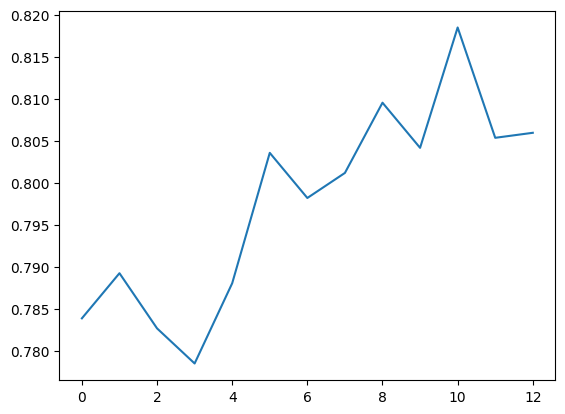

In [89]:
plt.plot([i for i in range(len(reports_neg_con_ful))], [report['accuracy'] for report in reports_neg_con_ful])

In [ ]:
print(reports_neg_con_ful_rob[-1])

In [ ]:
train_dataset_ful = DirtyDataset(train_detect_neg_consistency_ful_rob, train_labels_det_neg_consistency_rob)
val_dataset_ful = DirtyDataset(val_detect_neg_consistency_ful_rob, val_labels_det_neg_consistency_rob)
test_dataset_ful = DirtyDataset(test_detect_neg_consistency_ful_rob, test_labels_det_neg_consistency_rob)

train_loader_ful = torch.utils.data.DataLoader(train_dataset_ful, batch_size=len(train_dataset))
test_loader_ful = torch.utils.data.DataLoader(test_dataset_ful, batch_size=len(test_dataset))
val_loader_ful = torch.utils.data.DataLoader(val_dataset_ful, batch_size=len(val_dataset))


pl_cons_model_rob_ful = AcrossLayerfit(lr=0.001, model=torch.nn.Sequential(
                torch.nn.Linear(768, 500),
                torch.nn.ReLU(),
                torch.nn.Linear(500, 300),
                torch.nn.Tanh(),
                torch.nn.Linear(300, 150),
                torch.nn.ReLU(),
                torch.nn.Linear(150, 1),
                torch.nn.Sigmoid()
))

early_stopping = pytorch_lightning.callbacks.EarlyStopping('validation_loss', min_delta=0.0001, patience=10)
trainer = pytorch_lightning.Trainer(callbacks=[early_stopping], accelerator="gpu")
# trainer = pytorch_lightning.Trainer(accelerator="gpu", max_epochs=1000)


trainer.fit(model=pl_cons_model_rob_ful, train_dataloaders=train_loader_ful, val_dataloaders=val_loader_ful, )

In [105]:
trainer.test(model=pl_cons_model_rob_ful, dataloaders=test_loader_ful)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home2/shashwat.s/anaconda3/envs/new_research_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.7892537117004395
        test_loss           0.4629657566547394
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.4629657566547394, 'test_accuracy': 0.7892537117004395}]

In [106]:
train_detect_neg_consistency_ful_deb, train_labels_det_neg_consistency_deb = get_hidden_states_many_examples(model_wrapped_deberta, train_dataset_neg_consistency_deb, n=8000, batch_size=100, query_column="masked_non_negated")
val_detect_neg_consistency_ful_deb, val_labels_det_neg_consistency_deb = get_hidden_states_many_examples(model_wrapped_deberta, dev_dataset_neg_consistency_deb, n=2000, batch_size=100, query_column="masked_non_negated")
test_detect_neg_consistency_ful_deb, test_labels_det_neg_consistency_deb = get_hidden_states_many_examples(model_wrapped_deberta, test_dataset_neg_consistency_deb, n=2000, batch_size=100, query_column="masked_non_negated")


In [107]:
mlps_neg_con_full_deb, accuracies = run_experiment_across_layers(mlp_probe_experiment_custom, train_detect_neg_consistency_ful_deb, train_labels_det_neg_consistency_deb, test_detect_neg_consistency_ful_deb, test_labels_det_neg_consistency_deb)


here
Iteration 1, loss = 0.56870108
Validation score: 0.772233
Iteration 2, loss = 0.47651219
Validation score: 0.774152
Iteration 3, loss = 0.43169997
Validation score: 0.781830
Iteration 4, loss = 0.38385142
Validation score: 0.770313
Iteration 5, loss = 0.32977084
Validation score: 0.742163
Iteration 6, loss = 0.26948461
Validation score: 0.743442
Iteration 7, loss = 0.20265518
Validation score: 0.762636
Iteration 8, loss = 0.14672558
Validation score: 0.746001
Iteration 9, loss = 0.09902357
Validation score: 0.757518
Iteration 10, loss = 0.06197195
Validation score: 0.755598
Iteration 11, loss = 0.05019612
Validation score: 0.734485
Iteration 12, loss = 0.04945240
Validation score: 0.756238
Iteration 13, loss = 0.02682640
Validation score: 0.754958
Iteration 14, loss = 0.02090715
Validation score: 0.749200
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
here
Iteration 1, loss = 0.61646520
Validation score: 0.753679
Iteration 2, loss = 0.

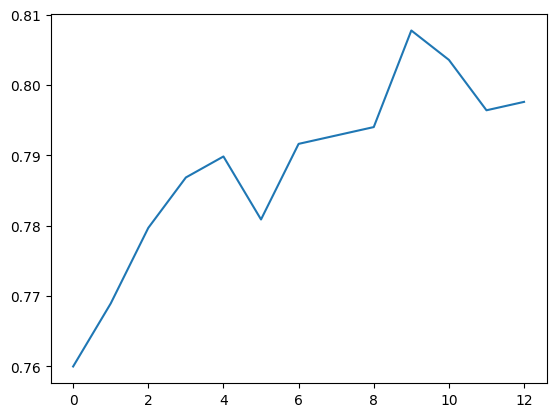

In [108]:
reports_neg_con_ful_deb = generate_classification_report_all_layers(test_detect_neg_consistency_ful_deb, test_labels_det_neg_consistency_deb, mlps_neg_con_full_deb)
plt.plot([i for i in range(len(reports_neg_con_ful_deb))], [report['accuracy'] for report in reports_neg_con_ful_deb])


In [ ]:
train_dataset_ful_deb = DirtyDataset(train_detect_neg_consistency_ful_deb, train_labels_det_neg_consistency_deb)
val_dataset_ful_deb = DirtyDataset(val_detect_neg_consistency_ful_deb, val_labels_det_neg_consistency_deb)
test_dataset_ful_deb = DirtyDataset(test_detect_neg_consistency_ful_deb, test_labels_det_neg_consistency_deb)

train_loader_ful_deb = torch.utils.data.DataLoader(train_dataset_ful_deb, batch_size=len(train_dataset_deb))
test_loader_ful_deb = torch.utils.data.DataLoader(test_dataset_ful_deb, batch_size=len(test_dataset_deb))
val_loader_ful_deb = torch.utils.data.DataLoader(val_dataset_ful_deb, batch_size=len(val_dataset_deb))


pl_cons_model_deb_ful = AcrossLayerfit(lr=0.001, model=torch.nn.Sequential(
                torch.nn.Linear(768, 500),
                torch.nn.ReLU(),
                torch.nn.Linear(500, 300),
                torch.nn.Tanh(),
                torch.nn.Linear(300, 150),
                torch.nn.ReLU(),
                torch.nn.Linear(150, 1),
                torch.nn.Sigmoid()
))

early_stopping = pytorch_lightning.callbacks.EarlyStopping('validation_loss', min_delta=0.0001, patience=10)
trainer = pytorch_lightning.Trainer(callbacks=[early_stopping], accelerator="gpu")
# trainer = pytorch_lightning.Trainer(accelerator="gpu", max_epochs=1000)


trainer.fit(model=pl_cons_model_deb_ful, train_dataloaders=train_loader_ful_deb, val_dataloaders=val_loader_ful_deb, )

In [110]:
trainer.test(model=pl_cons_model_deb_ful, dataloaders=test_loader_ful_deb)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home2/shashwat.s/anaconda3/envs/new_research_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.7994030117988586
        test_loss           0.4462116062641144
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.4462116062641144, 'test_accuracy': 0.7994030117988586}]

In [111]:
print(reports_neg_con_ful_rob[-1])
print(reports_neg_con_ful_deb[-1])

{'0': {'precision': 0.8382193268186754, 'recall': 0.8092243186582809, 'f1-score': 0.8234666666666668, 'support': 954}, '1': {'precision': 0.7586206896551724, 'recall': 0.7933425797503467, 'f1-score': 0.7755932203389831, 'support': 721}, 'accuracy': 0.8023880597014925, 'macro avg': {'precision': 0.7984200082369239, 'recall': 0.8012834492043138, 'f1-score': 0.7995299435028249, 'support': 1675}, 'weighted avg': {'precision': 0.8039562716575496, 'recall': 0.8023880597014925, 'f1-score': 0.8028596488742729, 'support': 1675}}
{'0': {'precision': 0.7928483353884094, 'recall': 0.7899262899262899, 'f1-score': 0.7913846153846155, 'support': 814}, '1': {'precision': 0.8020833333333334, 'recall': 0.8048780487804879, 'f1-score': 0.8034782608695653, 'support': 861}, 'accuracy': 0.7976119402985075, 'macro avg': {'precision': 0.7974658343608714, 'recall': 0.7974021693533888, 'f1-score': 0.7974314381270904, 'support': 1675}, 'weighted avg': {'precision': 0.7975954000036808, 'recall': 0.7976119402985075

## Negation consistency given just the relation

In [12]:
train_detect_neg_consistency_rel_rob, train_labels_det_neg_consistency_rob = get_hidden_states_many_examples(model_wrapped, train_dataset_neg_consistency_sorted_cut_rob, n=8000, batch_size=100, query_column="subject_hidden")
test_detect_neg_consistency_rel_rob, test_labels_det_neg_consistency_rob = get_hidden_states_many_examples(model_wrapped, test_dataset_neg_consistency_rob, n=2000, batch_size=100, query_column="subject_hidden")
val_detect_neg_consistency_rel_rob, val_labels_det_neg_consistency_rob = get_hidden_states_many_examples(model_wrapped, dev_dataset_neg_consistency_rob, n=2000, batch_size=100, query_column="subject_hidden")


In [13]:
train_detect_neg_consistency_rel_deb, train_labels_det_neg_consistency_deb = get_hidden_states_many_examples(model_wrapped_deberta, train_dataset_neg_consistency_deb, n=8000, batch_size=100, query_column="subject_hidden")
test_detect_neg_consistency_rel_deb, test_labels_det_neg_consistency_deb = get_hidden_states_many_examples(model_wrapped_deberta, test_dataset_neg_consistency_deb, n=2000, batch_size=100, query_column="subject_hidden")
val_detect_neg_consistency_rel_deb, val_labels_det_neg_consistency_deb = get_hidden_states_many_examples(model_wrapped_deberta, dev_dataset_neg_consistency_deb, n=2000, batch_size=100, query_column="subject_hidden")


In [14]:
train_val_detect_neg_consistency_rel_deb = [torch.cat((train_detect_neg_consistency_rel_deb[i], val_detect_neg_consistency_rel_deb[i]), dim=0) for i in range(len(train_detect_neg_consistency_rel_deb))]
train_val_detect_neg_consistency_label_deb = torch.cat((train_labels_det_neg_consistency_deb, val_labels_det_neg_consistency_deb), dim=0)

train_val_detect_neg_consistency_rel_rob = [torch.cat((train_detect_neg_consistency_rel_rob[i], val_detect_neg_consistency_rel_rob[i]), dim=0) for i in range(len(train_detect_neg_consistency_rel_rob))]
train_val_detect_neg_consistency_label_rob = torch.cat((train_labels_det_neg_consistency_rob, val_labels_det_neg_consistency_rob), dim=0)



In [17]:
mlps_neg_con_rel_deb, accuracies = run_experiment_across_layers(mlp_probe_experiment_custom, train_val_detect_neg_consistency_rel_deb, train_val_detect_neg_consistency_label_deb, test_detect_neg_consistency_rel_deb, test_labels_det_neg_consistency_deb)


here
Iteration 1, loss = 0.60040733
Validation score: 0.685985
Iteration 2, loss = 0.57414086
Validation score: 0.692308
Iteration 3, loss = 0.56814736
Validation score: 0.694942
Iteration 4, loss = 0.56447469
Validation score: 0.698630
Iteration 5, loss = 0.56199191
Validation score: 0.699684
Iteration 6, loss = 0.56174990
Validation score: 0.695996
Iteration 7, loss = 0.55956049
Validation score: 0.704426
Iteration 8, loss = 0.56392865
Validation score: 0.700211
Iteration 9, loss = 0.55694601
Validation score: 0.694415
Iteration 10, loss = 0.55711318
Validation score: 0.705479
Iteration 11, loss = 0.55575770
Validation score: 0.695996
Iteration 12, loss = 0.55354237
Validation score: 0.699684
Iteration 13, loss = 0.55443288
Validation score: 0.693888
Iteration 14, loss = 0.55377555
Validation score: 0.699157
Iteration 15, loss = 0.55278538
Validation score: 0.694942
Iteration 16, loss = 0.55435222
Validation score: 0.704953
Iteration 17, loss = 0.55367721
Validation score: 0.693888
I

In [18]:
mlps_neg_con_rel_rob, accuracies = run_experiment_across_layers(mlp_probe_experiment_custom, train_val_detect_neg_consistency_rel_rob, train_val_detect_neg_consistency_label_rob, test_detect_neg_consistency_rel_rob, test_labels_det_neg_consistency_rob)


here
Iteration 1, loss = 0.58637010
Validation score: 0.760316
Iteration 2, loss = 0.51117721
Validation score: 0.762136
Iteration 3, loss = 0.50398537
Validation score: 0.762136
Iteration 4, loss = 0.49545252
Validation score: 0.765777
Iteration 5, loss = 0.49467275
Validation score: 0.766990
Iteration 6, loss = 0.49432758
Validation score: 0.766383
Iteration 7, loss = 0.49023422
Validation score: 0.766383
Iteration 8, loss = 0.48831794
Validation score: 0.763350
Iteration 9, loss = 0.49304792
Validation score: 0.737864
Iteration 10, loss = 0.48869110
Validation score: 0.767597
Iteration 11, loss = 0.48984865
Validation score: 0.765777
Iteration 12, loss = 0.48793994
Validation score: 0.741505
Iteration 13, loss = 0.48638180
Validation score: 0.766990
Iteration 14, loss = 0.48529839
Validation score: 0.754854
Iteration 15, loss = 0.48666434
Validation score: 0.766990
Iteration 16, loss = 0.48538884
Validation score: 0.767597
Iteration 17, loss = 0.48354592
Validation score: 0.767597
I

In [20]:
reports_neg_con_rel_deb = generate_classification_report_all_layers(test_detect_neg_consistency_rel_deb, test_labels_det_neg_consistency_deb, mlps_neg_con_rel_deb)
reports_neg_con_rel_rob = generate_classification_report_all_layers(test_detect_neg_consistency_rel_rob, test_labels_det_neg_consistency_rob, mlps_neg_con_rel_rob)

print(reports_neg_con_rel_rob[-1])
print(reports_neg_con_rel_deb[-1])

{'0': {'precision': 0.8021547502448579, 'recall': 0.8584905660377359, 'f1-score': 0.829367088607595, 'support': 954}, '1': {'precision': 0.7935779816513762, 'recall': 0.7198335644937587, 'f1-score': 0.7549090909090909, 'support': 721}, 'accuracy': 0.7988059701492537, 'macro avg': {'precision': 0.7978663659481171, 'recall': 0.7891620652657473, 'f1-score': 0.792138089758343, 'support': 1675}, 'weighted avg': {'precision': 0.7984628994055145, 'recall': 0.7988059701492537, 'f1-score': 0.7973168101952838, 'support': 1675}}
{'0': {'precision': 0.6818580192813322, 'recall': 0.854006586169045, 'f1-score': 0.7582846003898636, 'support': 911}, '1': {'precision': 0.7509363295880149, 'recall': 0.524869109947644, 'f1-score': 0.6178736517719569, 'support': 764}, 'accuracy': 0.7038805970149253, 'macro avg': {'precision': 0.7163971744346735, 'recall': 0.6894378480583445, 'f1-score': 0.6880791260809103, 'support': 1675}, 'weighted avg': {'precision': 0.713365976937634, 'recall': 0.7038805970149253, 'f1